# Statistics on basic predictors

We are going to limit ourselves to a few basic predictors and later try more advanced techniqes on these basic ones.

The predictors to be used are: DecisionTree, SVM and LogisticRegression.

here we are going to train each of the above predictors and show it's accuracy on a test dataset.

In [20]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product
from random import sample
from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings

%matplotlib inline

pool = Pool()
ld = LearningData()

In [3]:
stock_names = sample(ld.get_stock_names(), 5)
stocks = [TrainingData(sn).add_history(10).get() for sn in stock_names]

In [4]:
import os
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

COH 4009
PMC 2296
KOP 2682
OMN 4270
SN 1188
             change         close   ex-divident          high           low  \
count  4.009000e+03  4.009000e+03  4.009000e+03  4.009000e+03  4.009000e+03   
mean   1.417895e-16 -3.828317e-16  7.089476e-18  2.835790e-17  1.701474e-16   
std    1.000125e+00  1.000125e+00  1.000125e+00  1.000125e+00  1.000125e+00   
min   -9.798524e-01 -2.397287e+00 -7.656374e-02 -2.412876e+00 -2.384349e+00   
25%   -6.606169e-01 -6.960624e-01 -7.656374e-02 -6.968635e-01 -6.959842e-01   
50%   -2.788379e-01 -2.098816e-01 -7.656374e-02 -2.154041e-01 -2.065557e-01   
75%    3.084509e-01  7.853590e-01 -7.656374e-02  7.767926e-01  7.747650e-01   
max    1.004552e+01  3.101867e+00  1.536659e+01  3.094629e+00  3.122544e+00   

               open   split_ratio       volume  change1_days_before  \
count  4.009000e+03  4.009000e+03  4009.000000         4.009000e+03   
mean  -7.089476e-17 -1.786548e-15     0.000000         1.417895e-16   
std    1.000125e+00  1.000125e+

In [14]:
def run_model(model):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, stocks):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

### Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
criterion=['gini', 'entropy']
max_depth=[1, 2, 5, 10, None]
# using percentages
min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

tmodels = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) 
          for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [8]:
taccuracies = list(map(run_model, tmodels))

In [9]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(tmodels, taccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, tacc))
tresults = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))

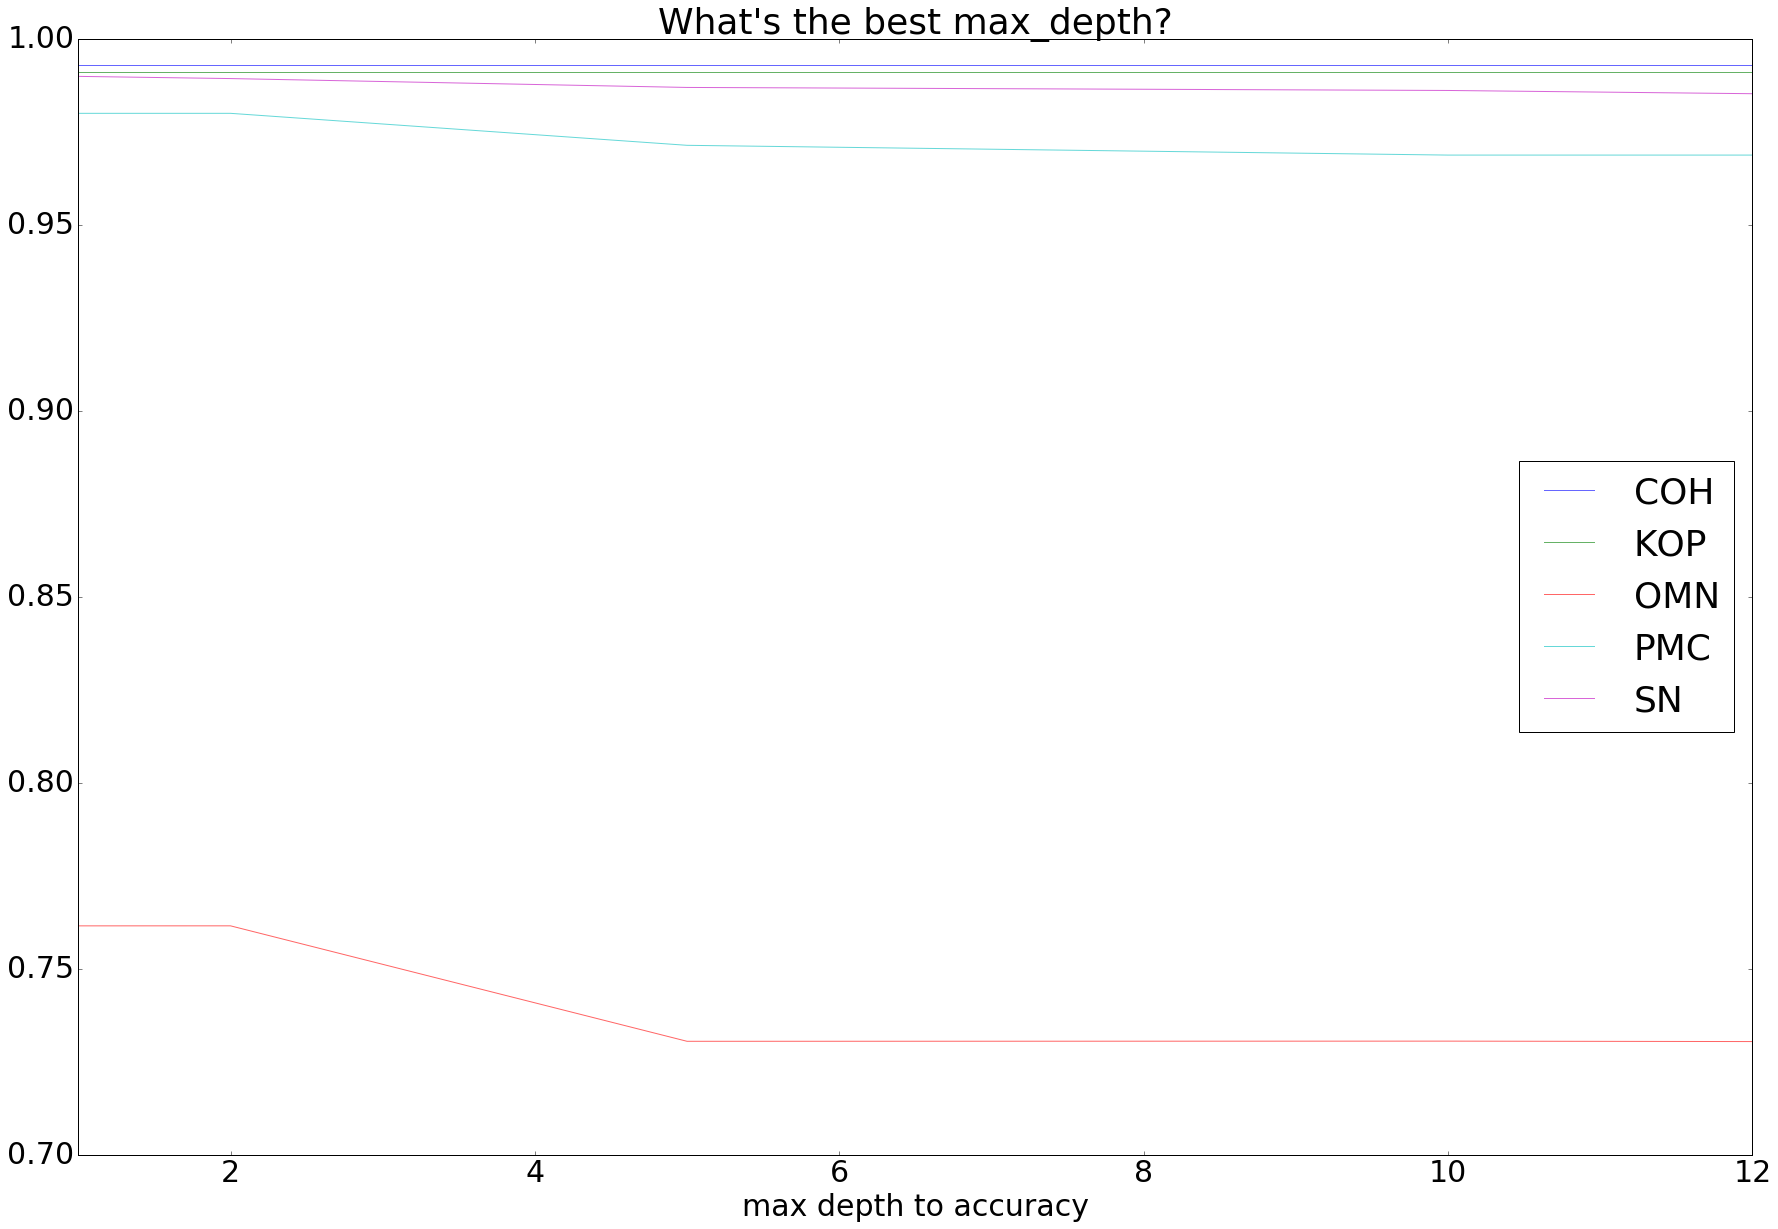

In [10]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

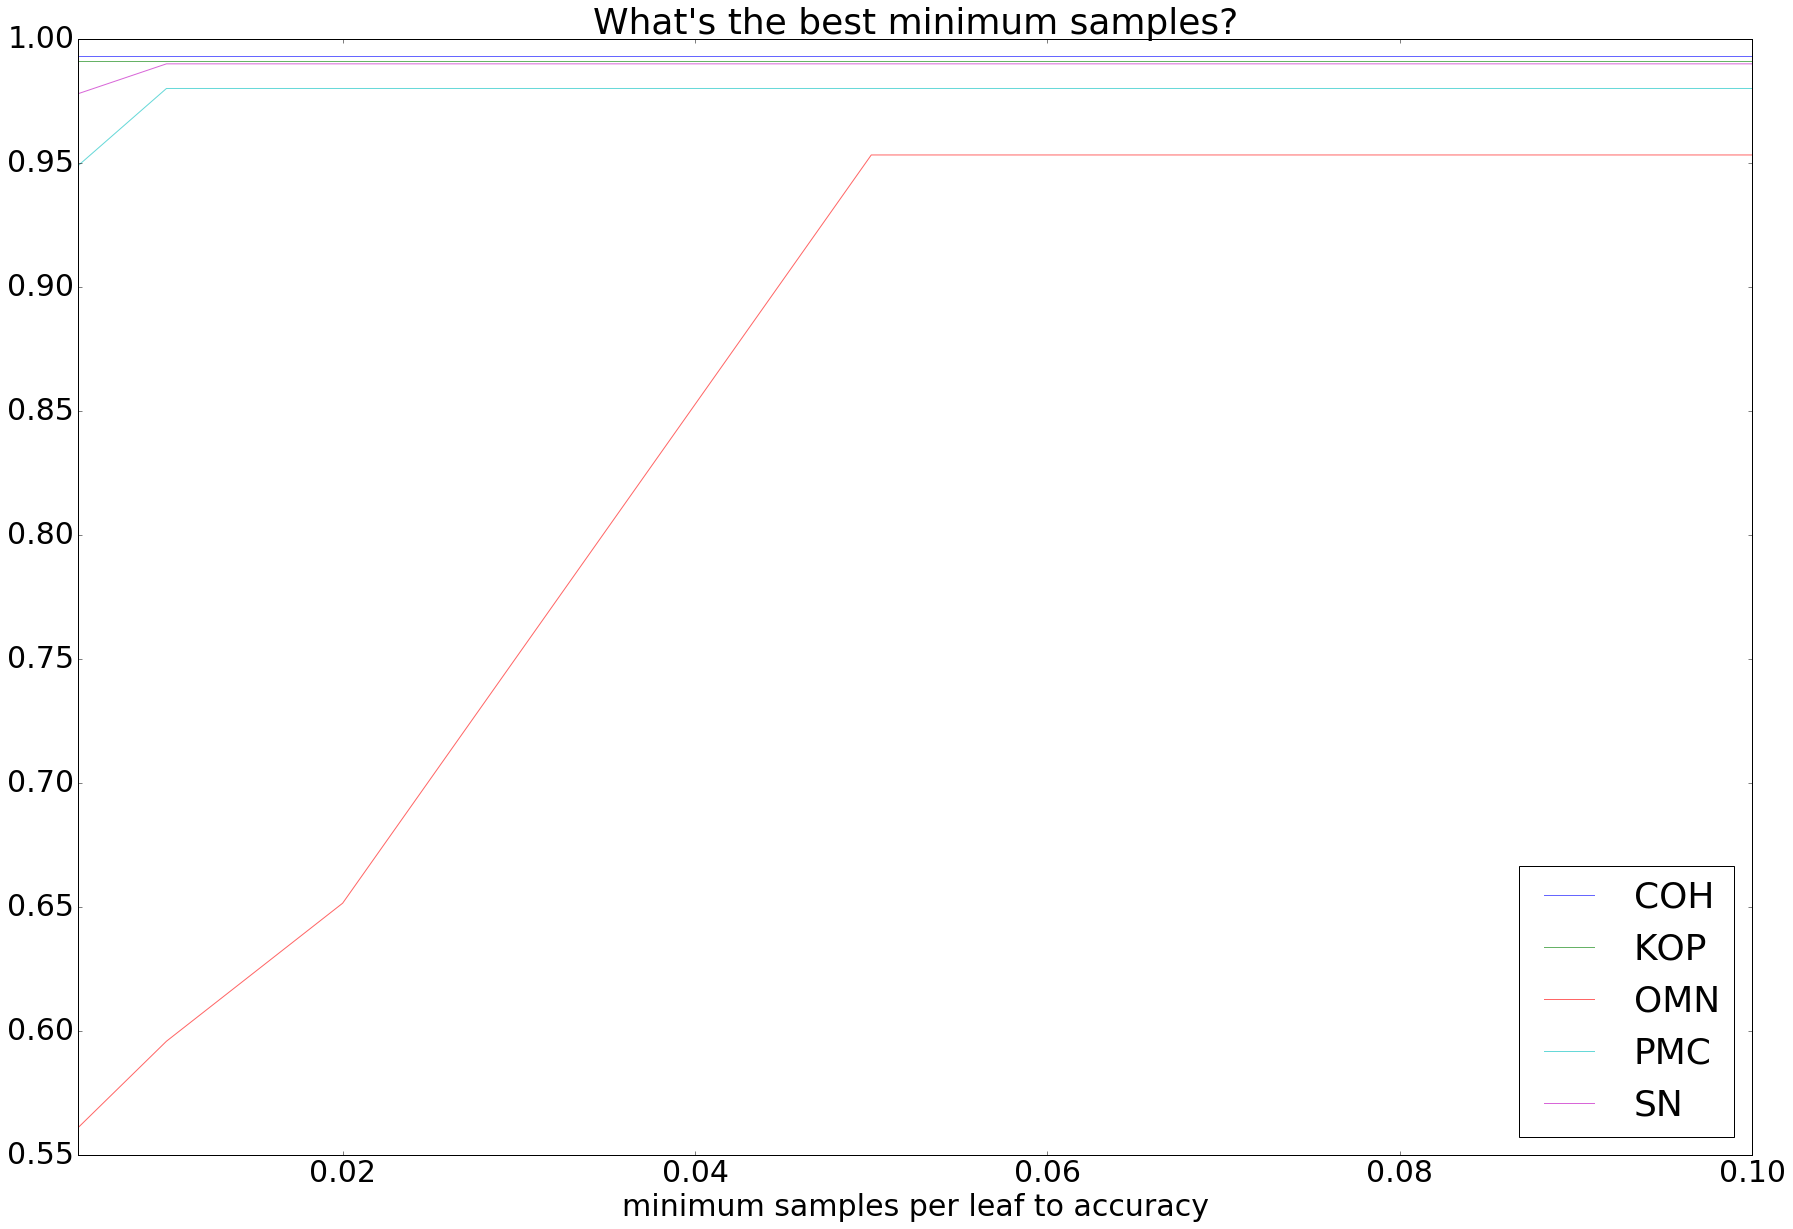

In [11]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best minimum samples?" )

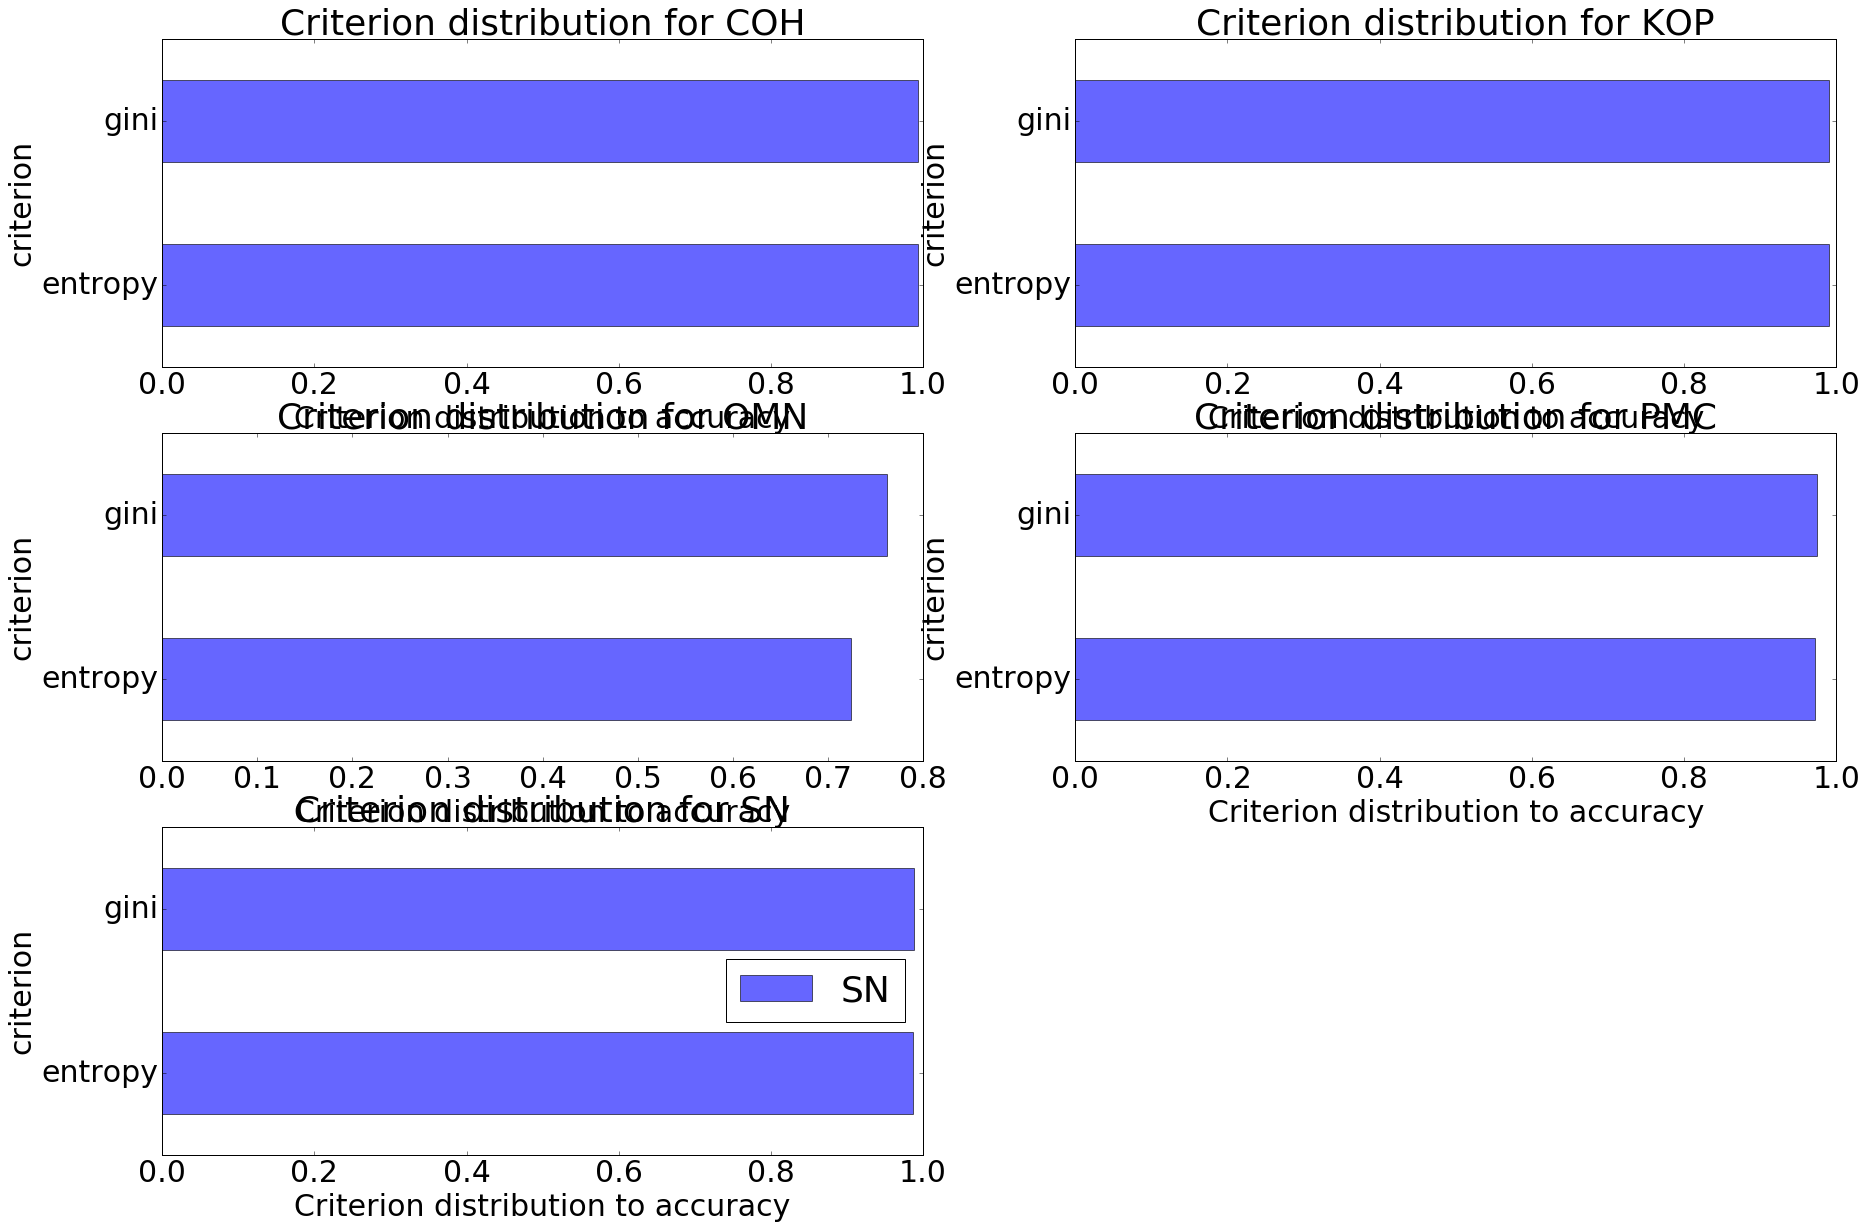

In [12]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(tresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution to accuracy')
    ax1.set_title("Criterion distribution for {}".format(name))
plt.legend(loc='best')


The best average accuracy model is:

In [16]:
print(get_best_model(tmodels, taccuracies))

(4.9070936020728038, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.05,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


which is like expected from graphs.

## SVM

We are using SVC which is a simple svm with different types of kernels.
All the data used is scaled using TrainingData. The classifier is not able to converge which is expected as out data is a mess (as it should be). The warnings are silenced for convinience.

In [17]:
from sklearn.svm import SVC
import traceback

# create iterables for all options and use itertools product
C=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
kernel=['linear', 'poly', 'rbf', 'sigmoid']
max_iter=[3, 10, 20, 100]

svm_models = [SVC(C=c, kernel=k, max_iter=mi) 
          for c, k, mi in product(C, kernel, max_iter)]

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    saccuracies = list(map(run_model, svm_models))

In [22]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(svm_models, saccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.kernel, model.max_iter, sn, acc))

sresults = DataFrame(data, columns=('C', 'kernel', 'max_iter', 'stock', 'accuracy'))

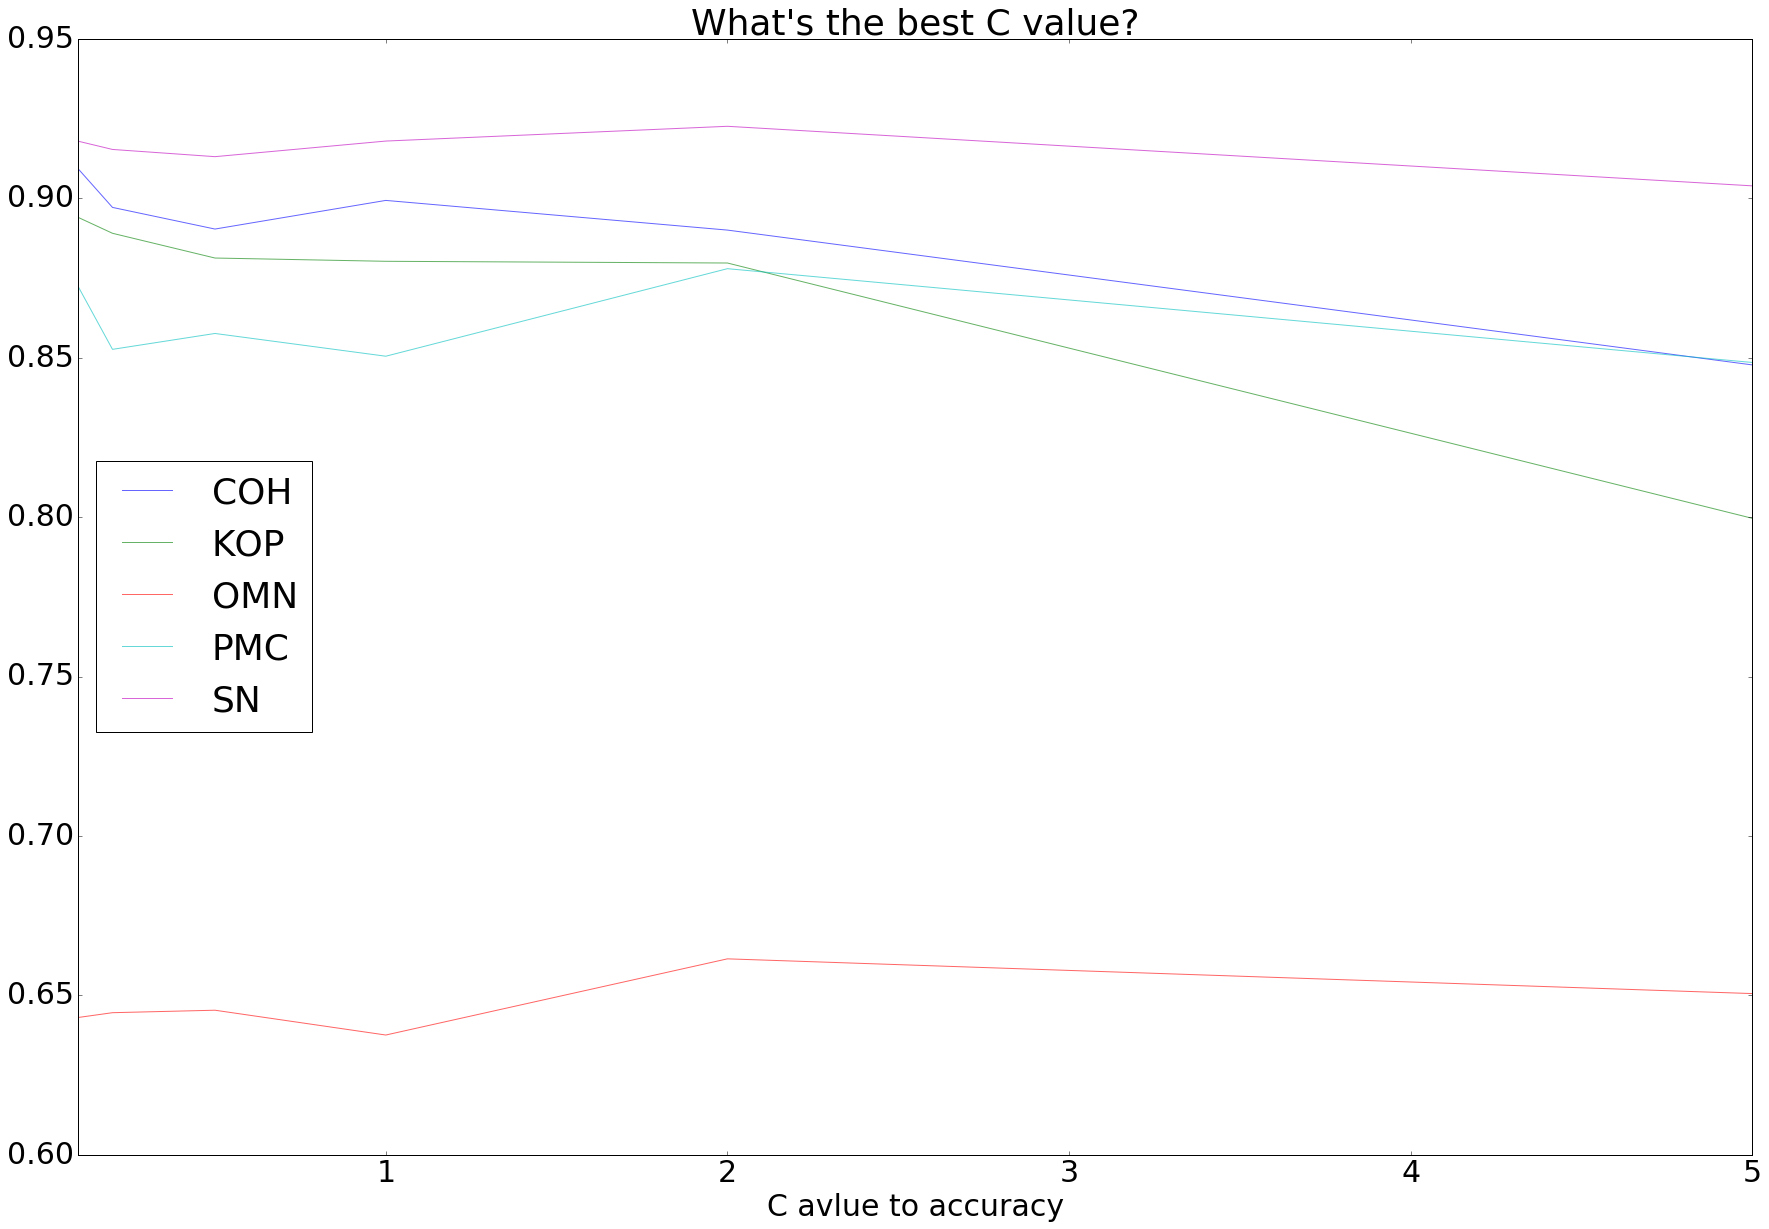

In [23]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

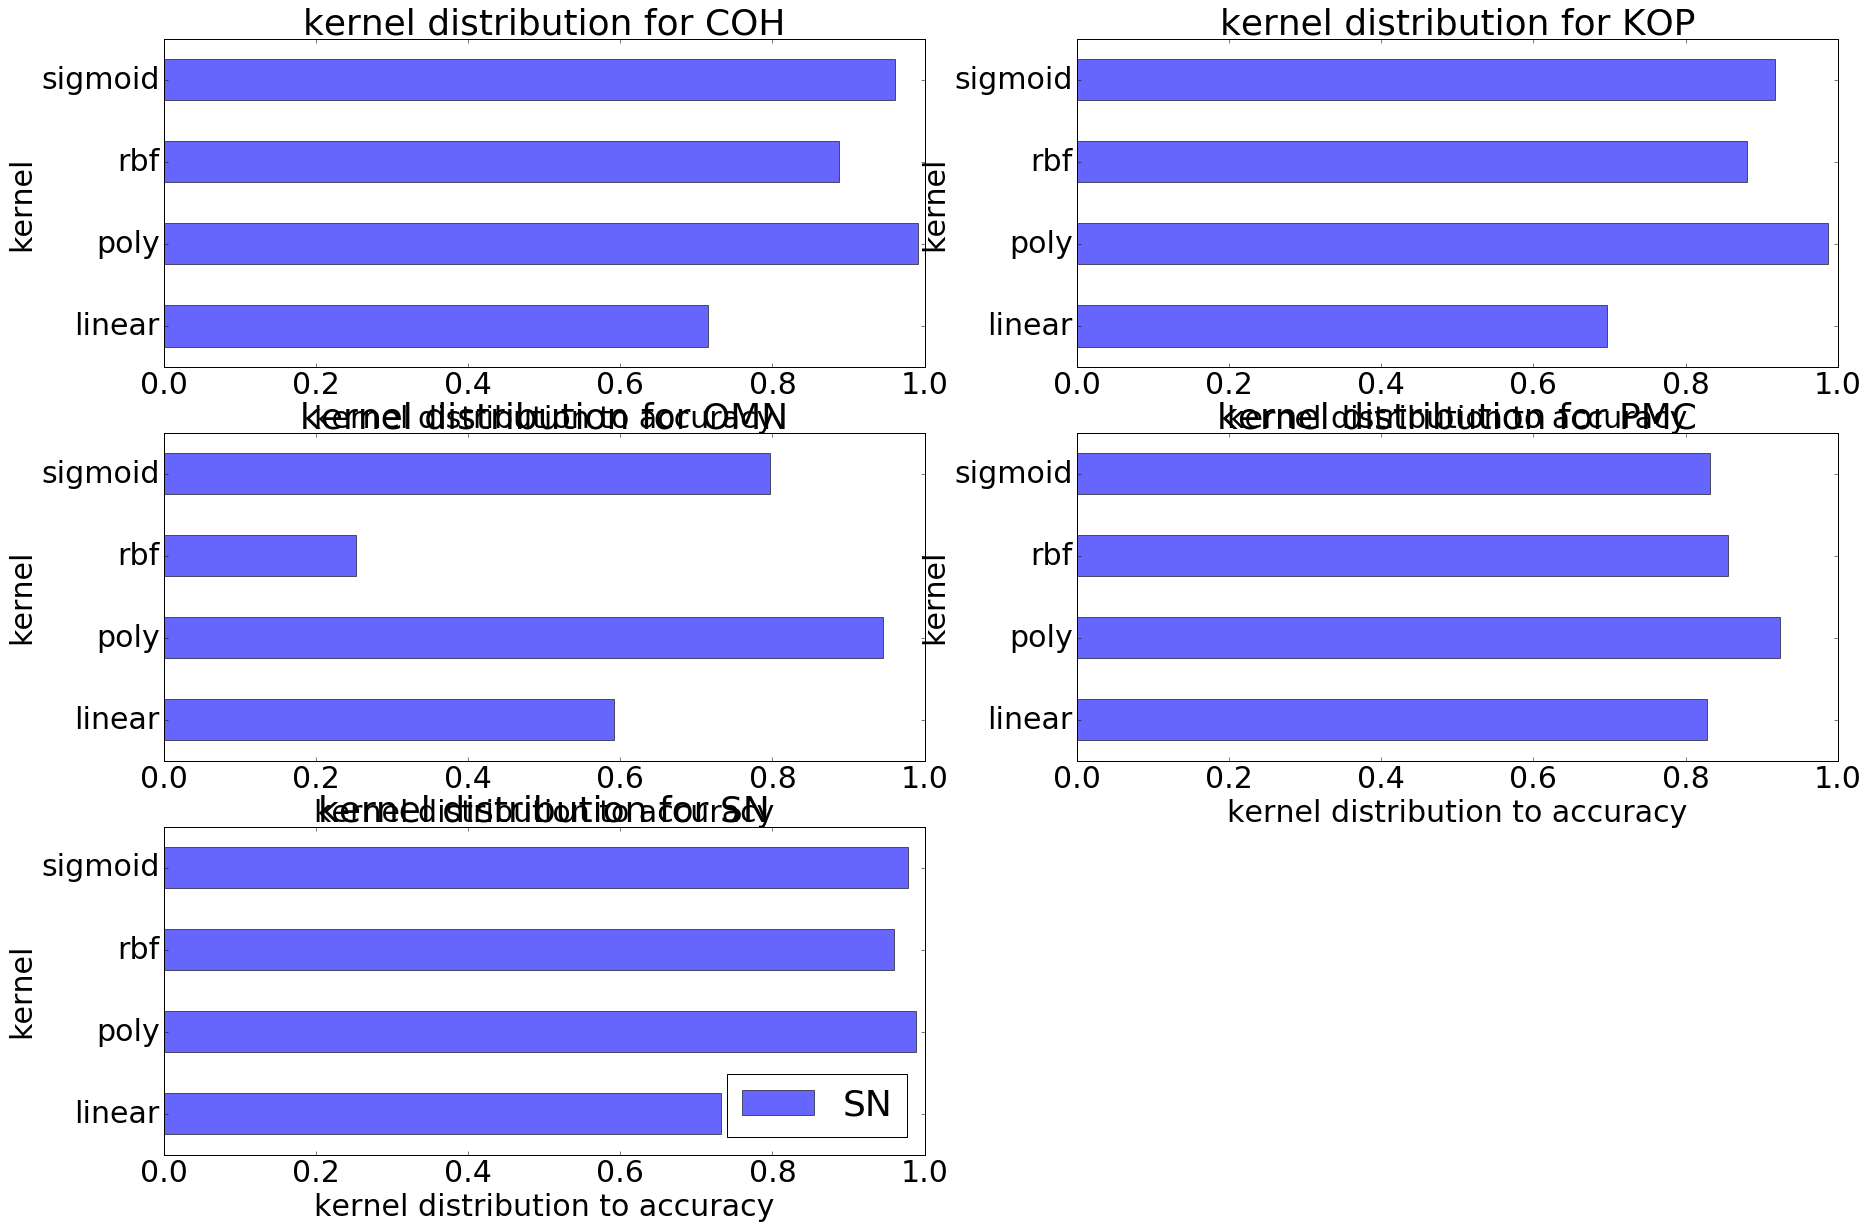

In [24]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(sresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('kernel').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution to accuracy')
    ax1.set_title("kernel distribution for {}".format(name))
plt.legend(loc='best')


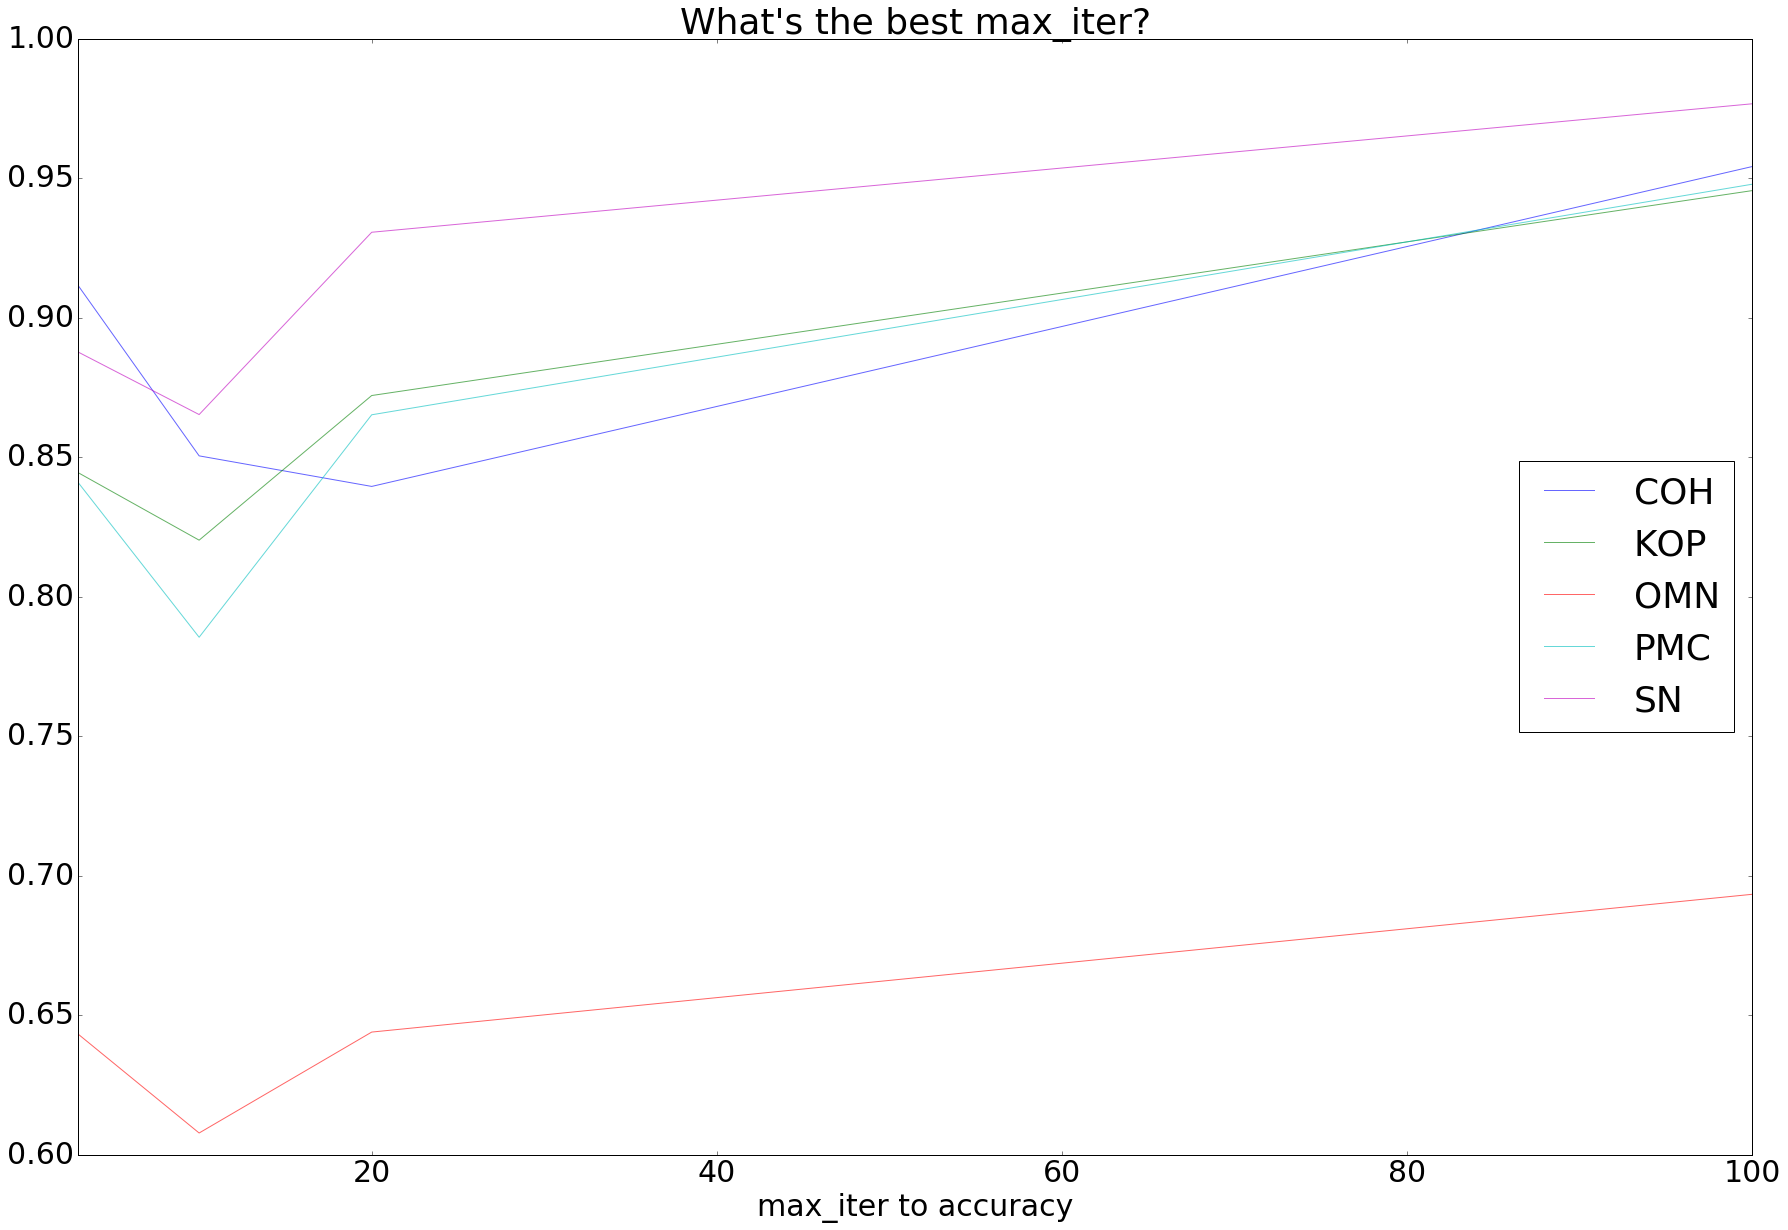

In [25]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

The best average accuracy model is:

In [27]:
print(get_best_model(svm_models, saccuracies))

(4.9055820389865543, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=3, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


Which is mostly expected the low max iteration. It might be caused because polynomial kernel converges faster then the others. 
Also 2 seems to be the best C value so we will check that too
Let us check:

In [28]:
polyresults = sresults.loc[sresults['kernel'] == 'poly']

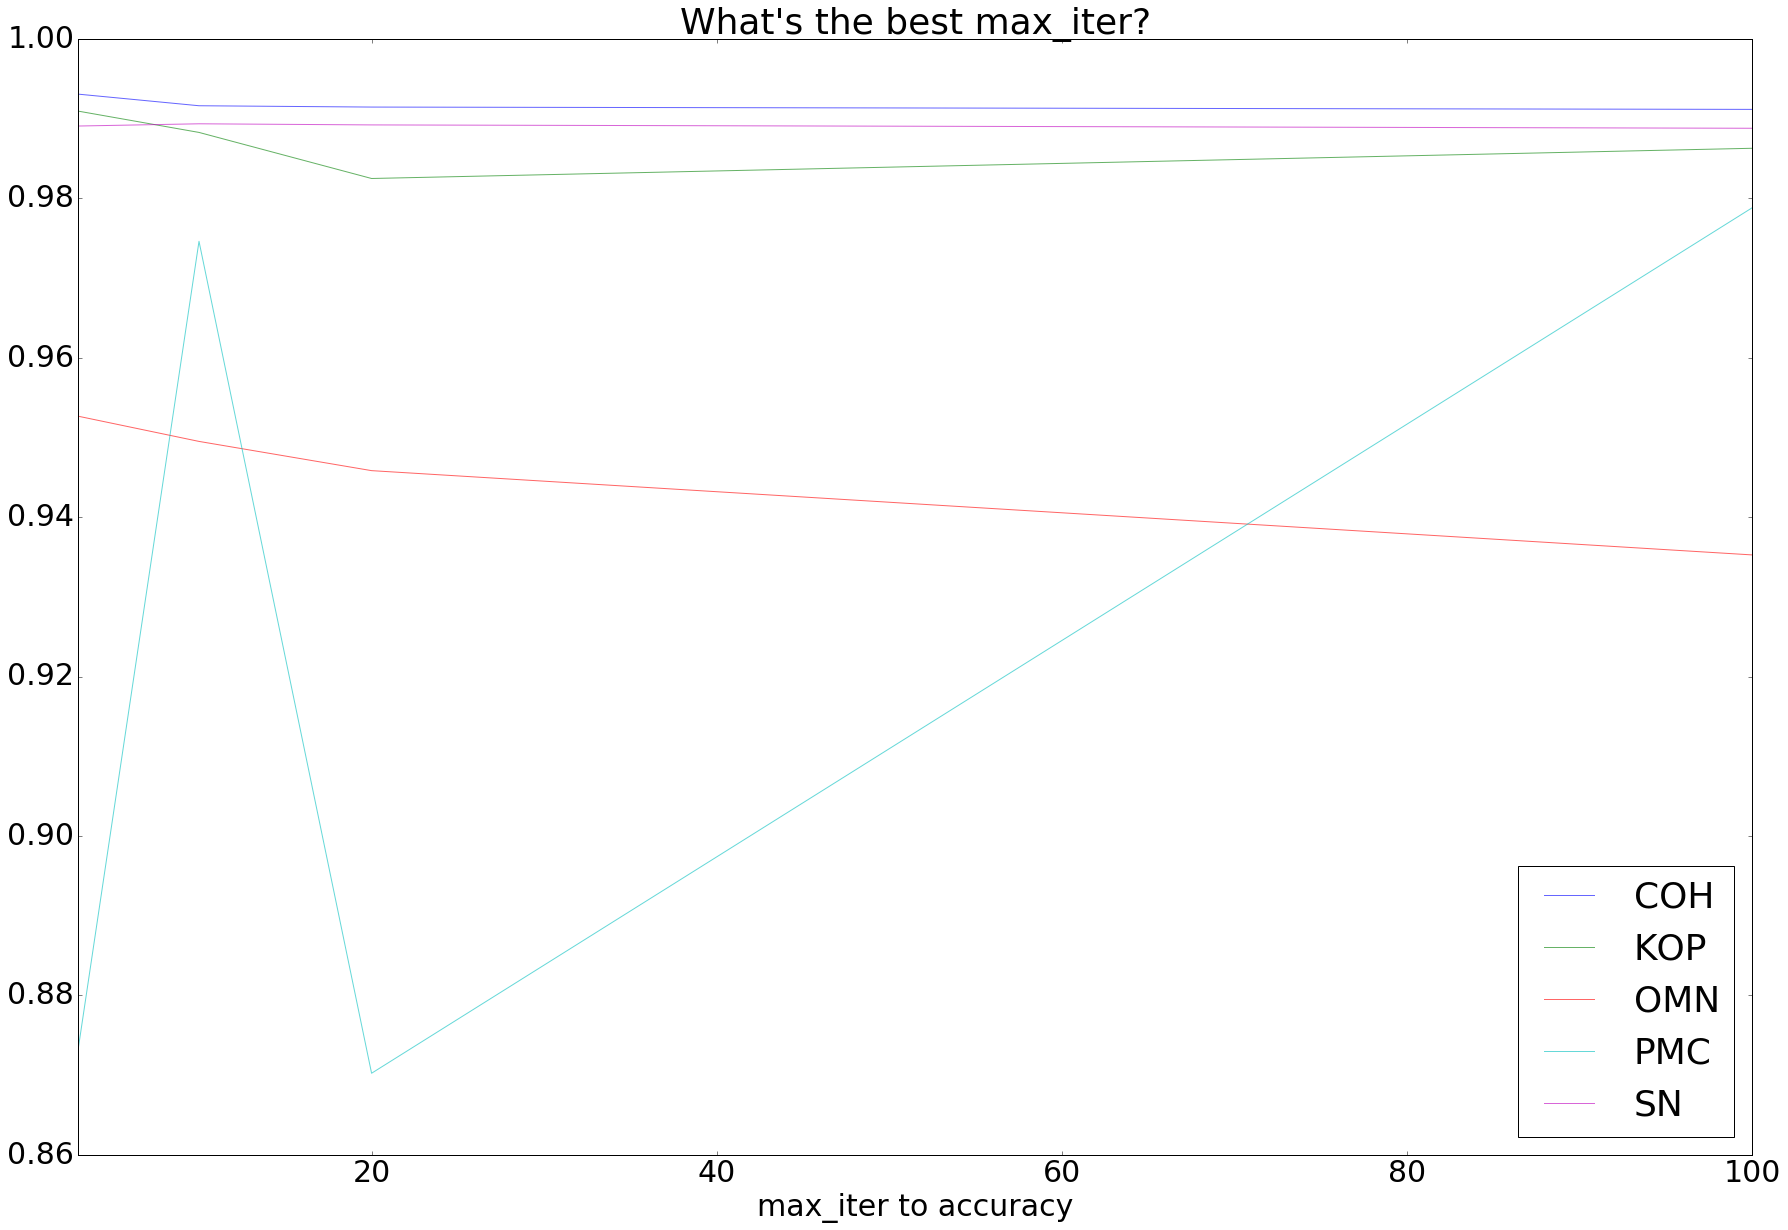

In [31]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in polyresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

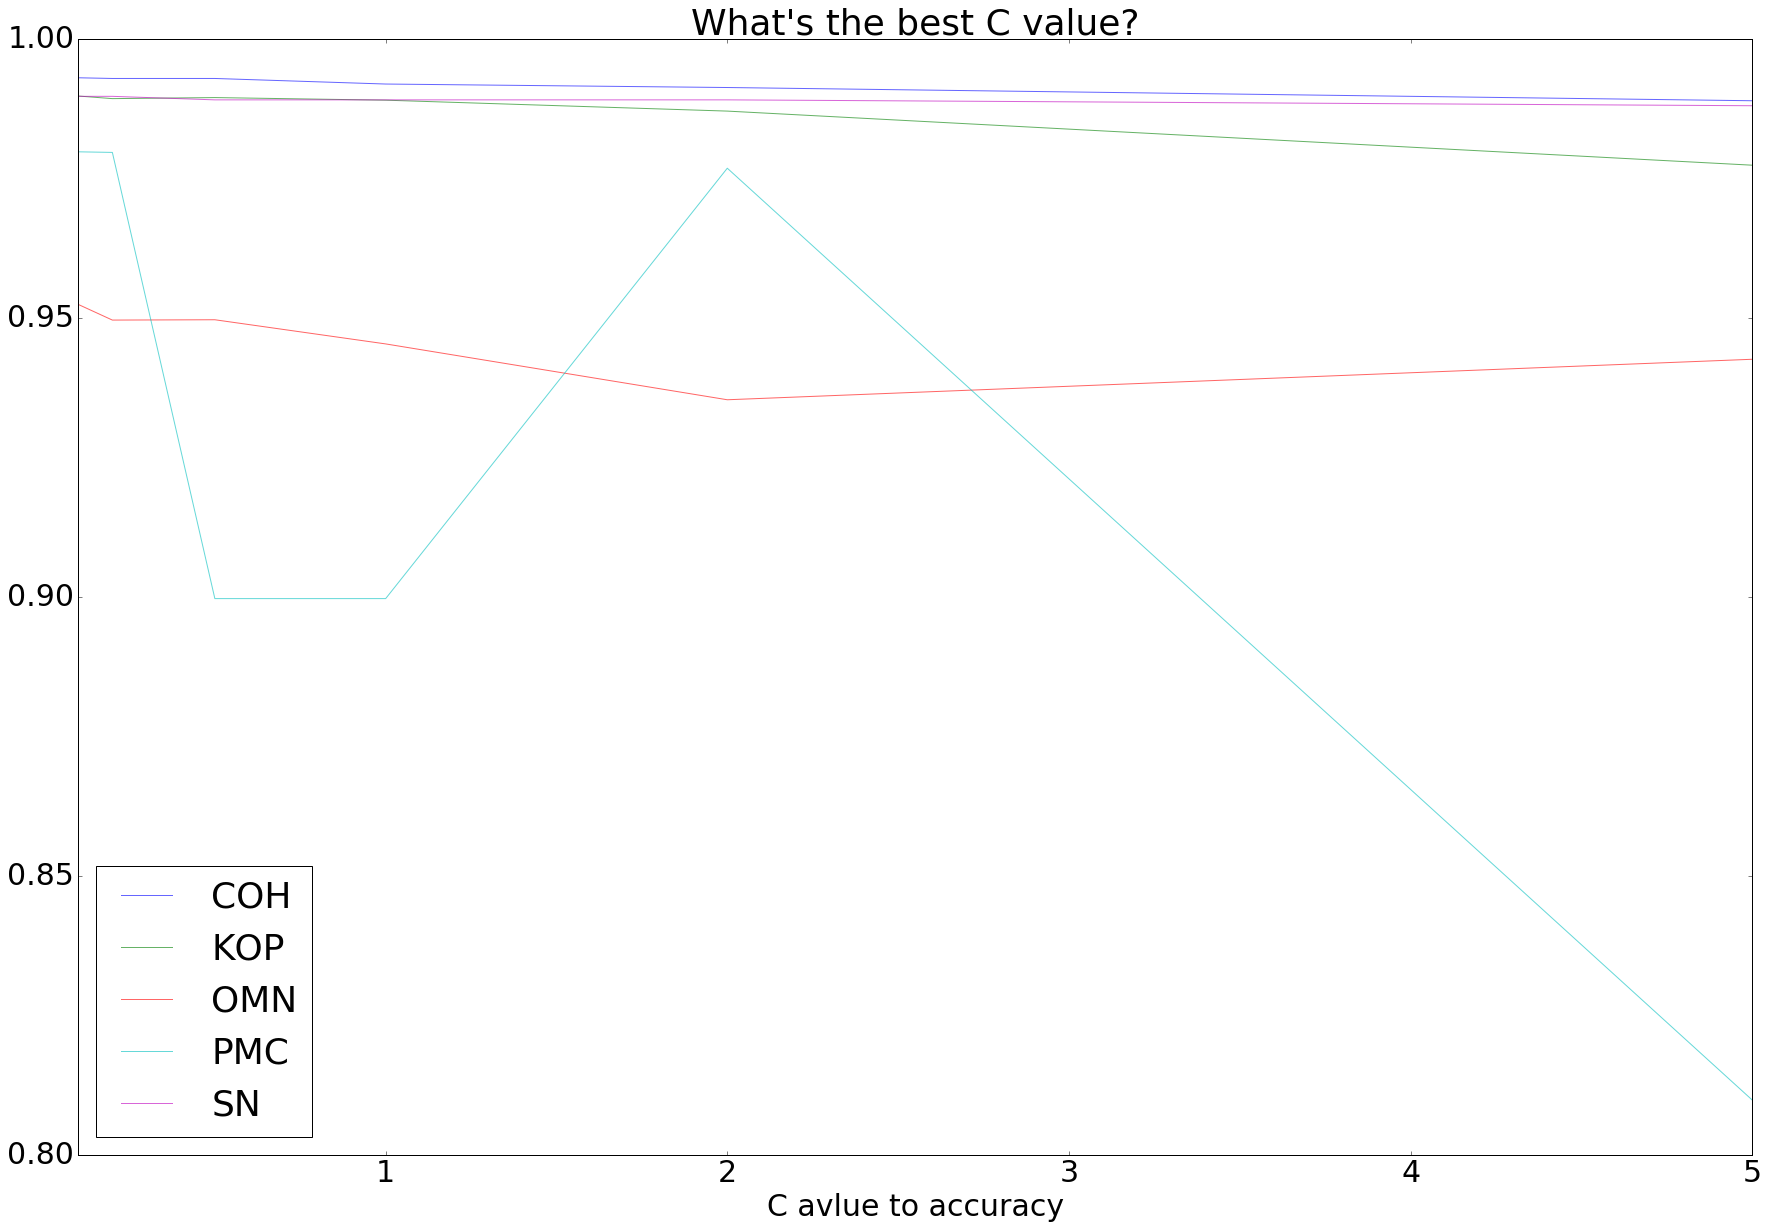

In [32]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in polyresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

From checking it seems truly a lower C valuie should be chosen.
We will need to choose for C=0.1, C=2 and either way kernel=poly and max_iter=100 and consider checking a more iterations.

## Logistic Regression

This one is pretty powerful and again with data scaled should work excelently. This is expected to bring the best results.

We will look at penalty function (norm), regularization strength (C param), intercept_scaling (the constant added to class calc, should play with this a little), max_iter and tol (tolerance for stopping).

In [33]:
from sklearn.linear_model import LogisticRegression

# create iterables for all options and use itertools product
penaltys = ['l1', 'l2']
Cs = [0.5, 0.7, 1.0, 1.3, 1.5]
intercept_scalings = [0.5, 0.7, 1.0, 1.3, 1.5]
max_iters = [3, 10, 20, 100]
tols = [0.00007, 0.0001, 0.0005]

lmodels = [LogisticRegression(C=c, penalty=p, intercept_scaling=isc, max_iter=mi, tol=t) 
          for c, p, isc, mi, t in product(Cs, penaltys, intercept_scalings, max_iters, tols)]

In [35]:
laccuracies = list(map(run_model, lmodels))

In [36]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(lmodels, laccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.penalty, model.intercept_scaling, model.max_iter, model.tol, sn, acc))

lresults = DataFrame(data, columns=('C', 'penalty', 'intercept_scaling', 'max_iter', 'tol', 'stock', 'accuracy'))

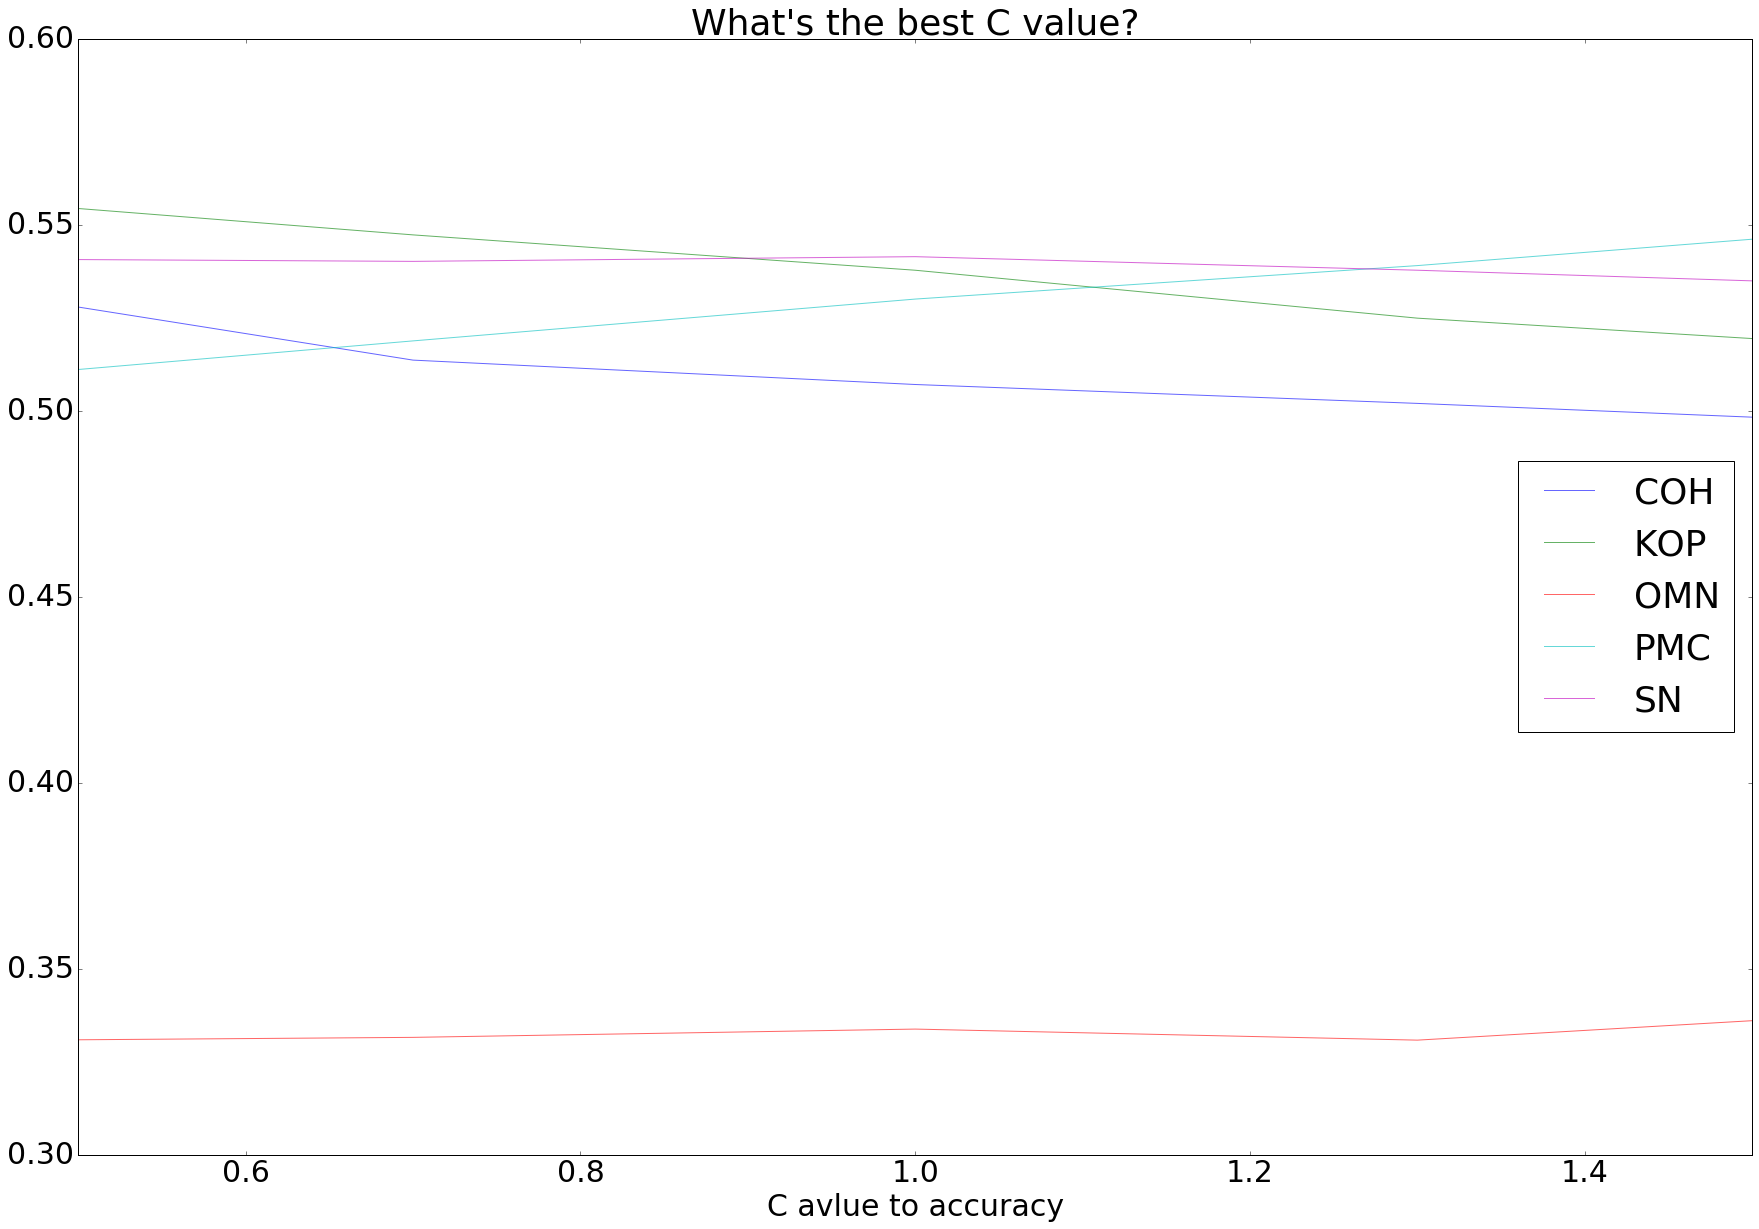

In [37]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

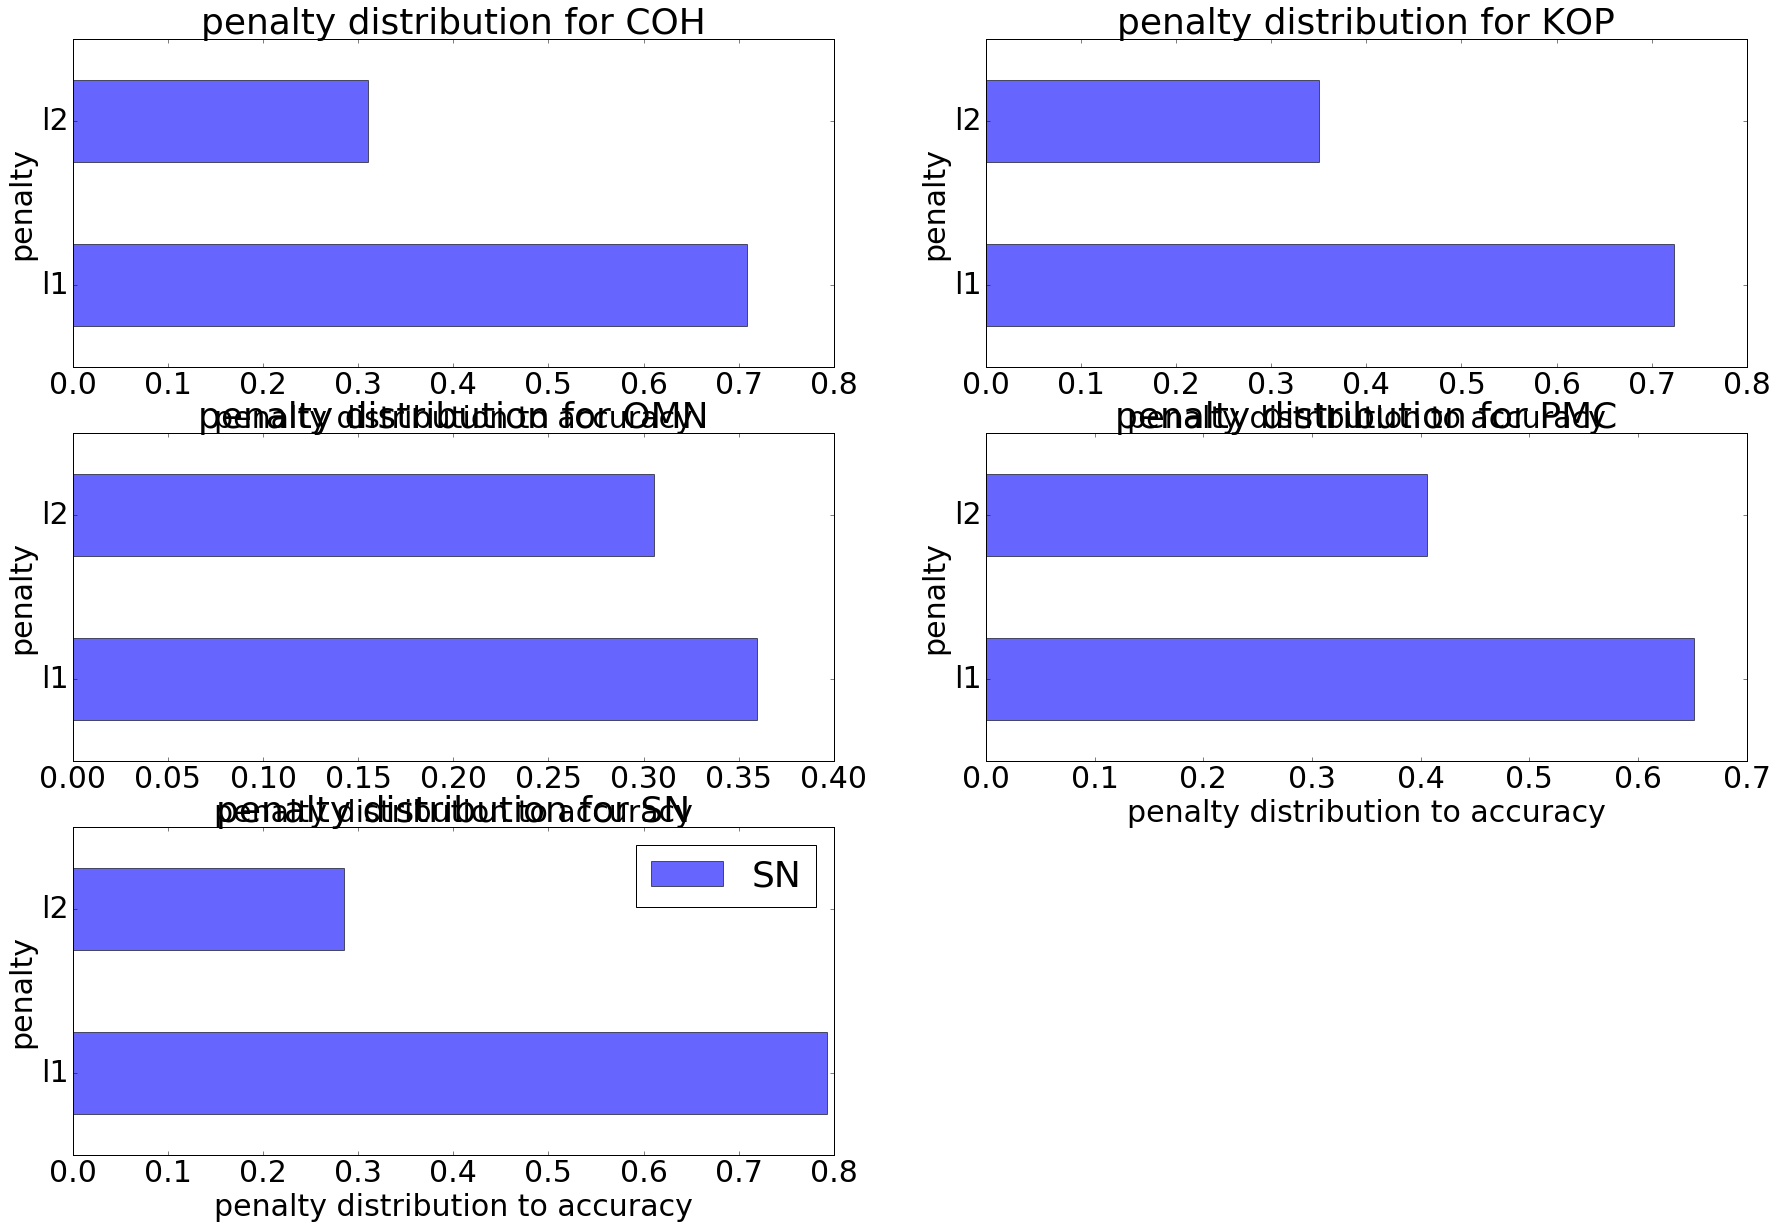

In [40]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(lresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('penalty').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('penalty distribution to accuracy')
    ax1.set_title("penalty distribution for {}".format(name))
plt.legend(loc='best')


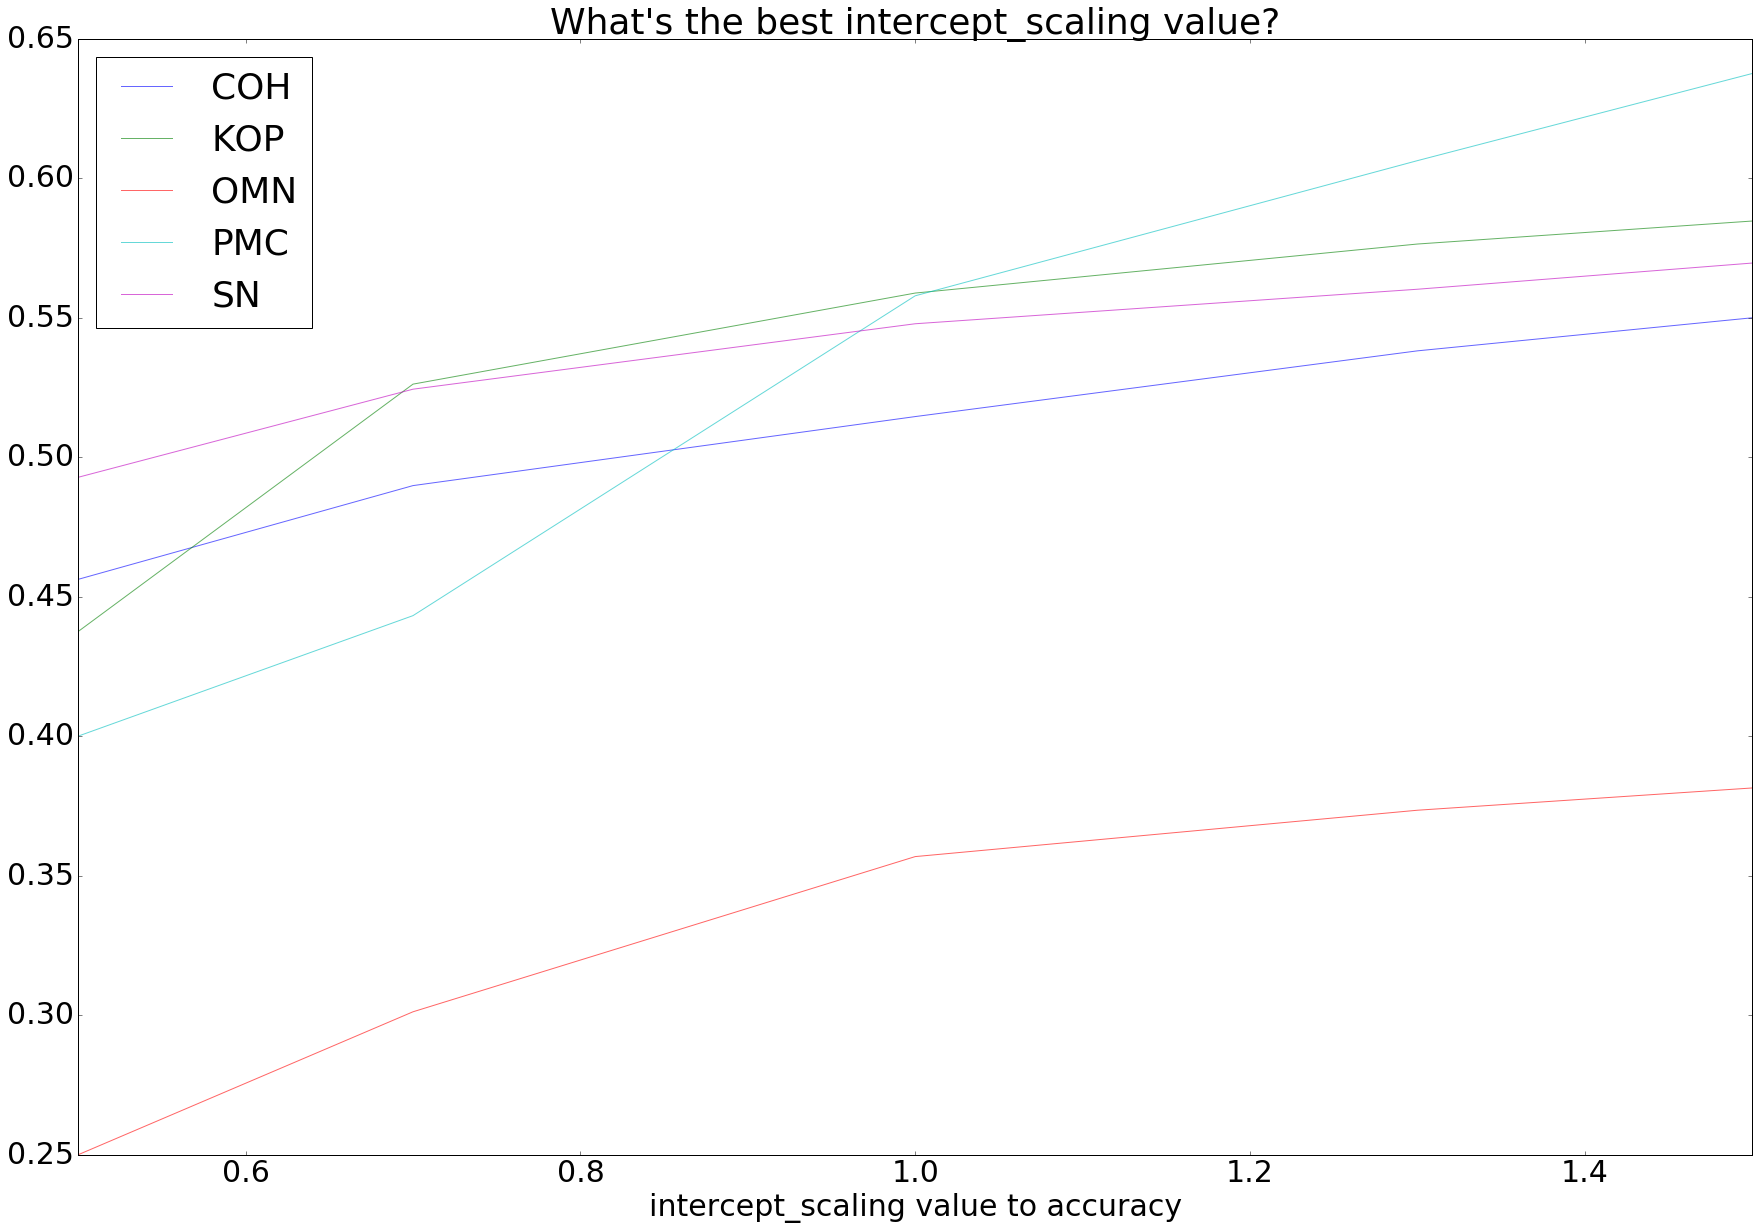

In [41]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('intercept_scaling value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best intercept_scaling value?" )

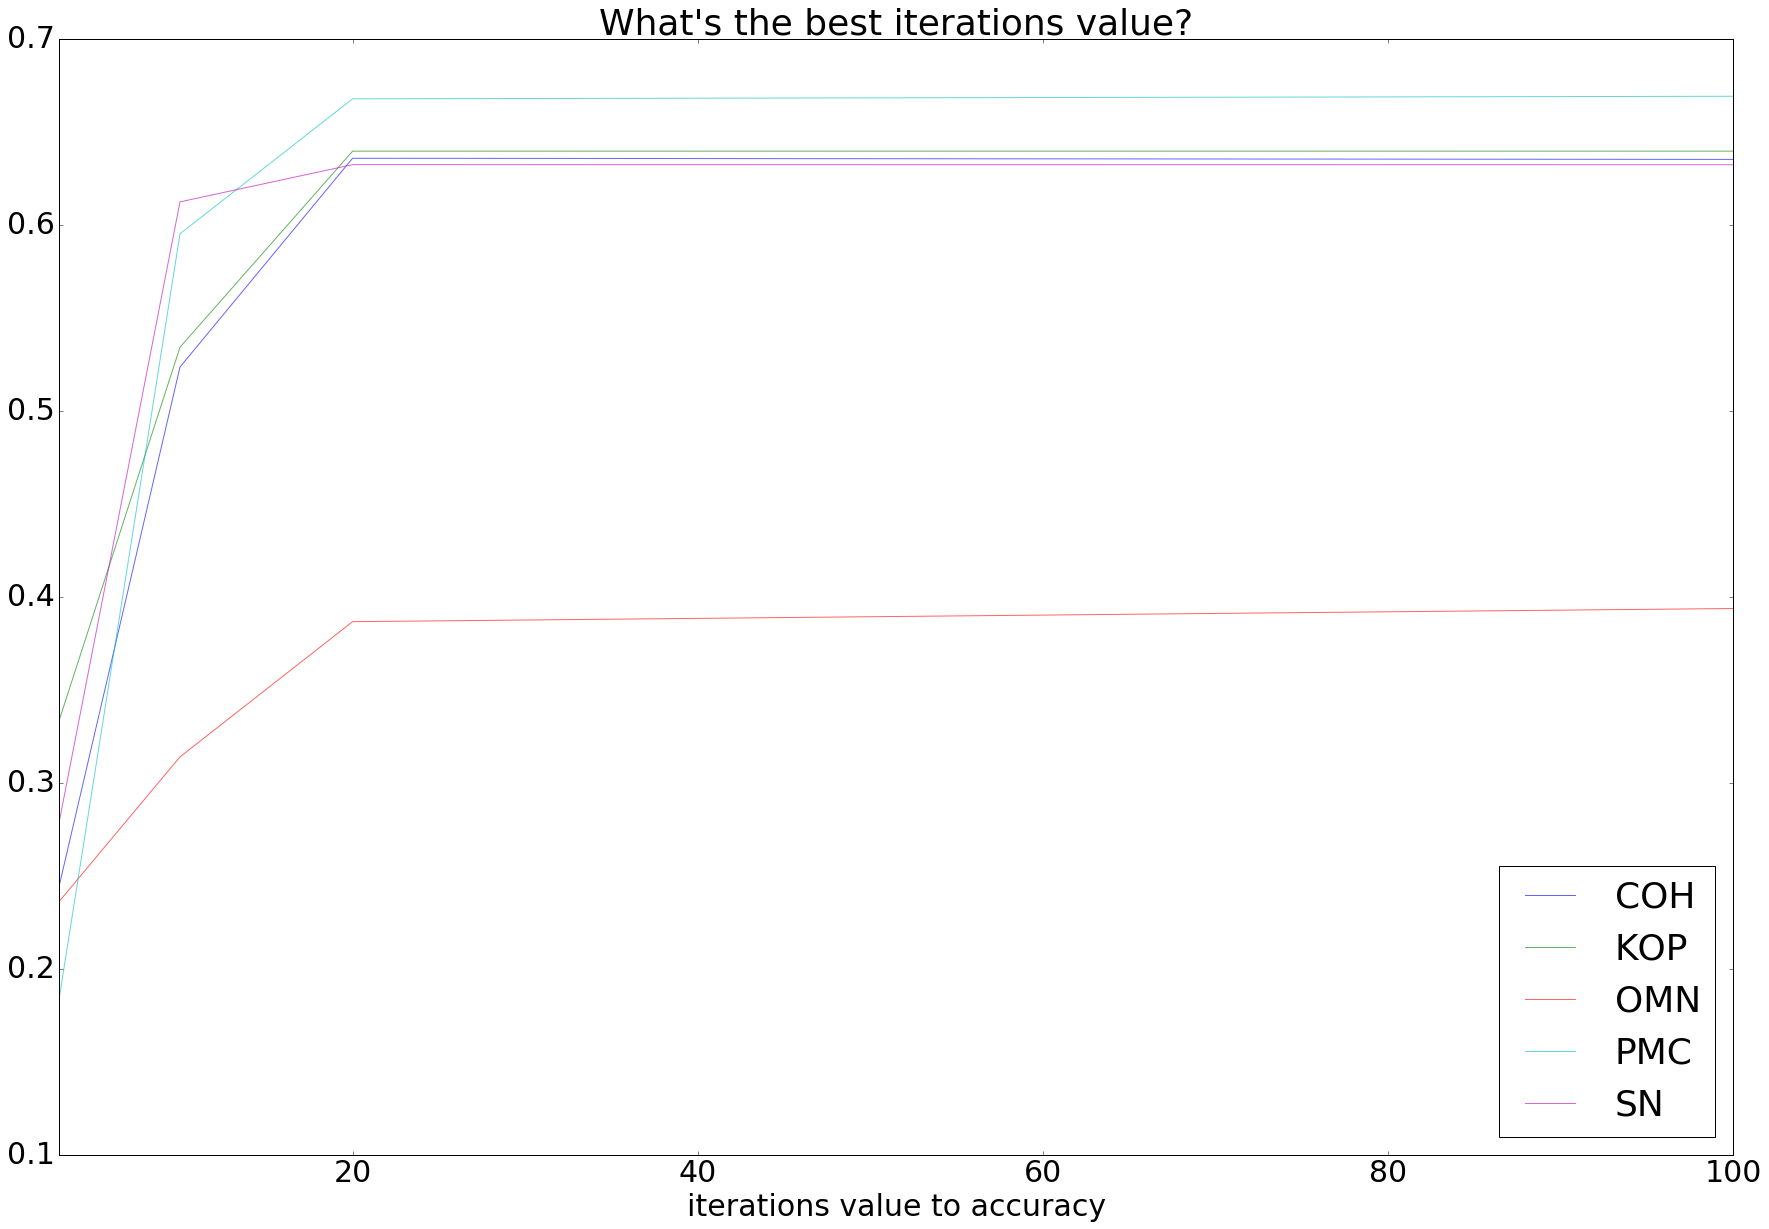

In [42]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('iterations value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best iterations value?" )

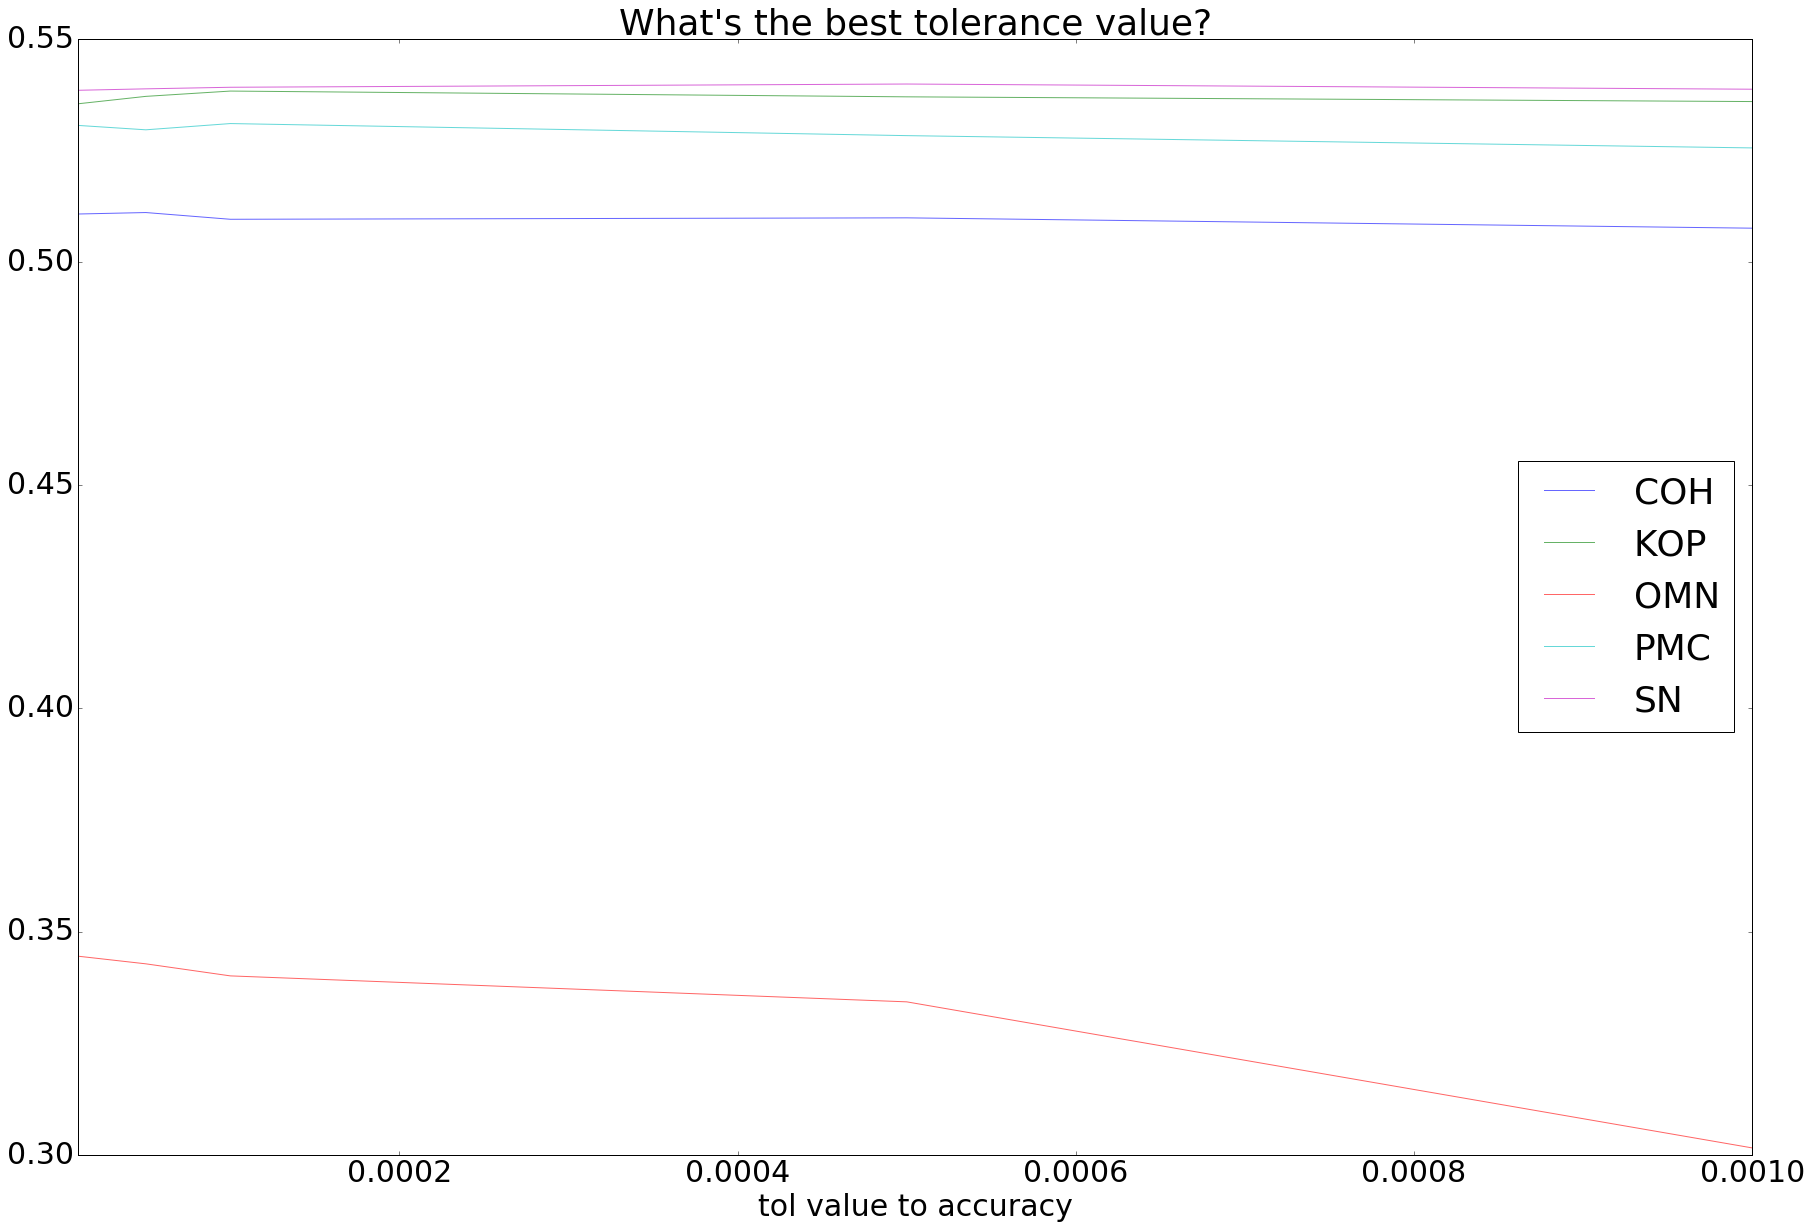

In [43]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('tol').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('tol value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best tolerance value?" )

In [44]:
print(get_best_model(lmodels, laccuracies))

(4.5121009239536303, LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.5, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0005,
          verbose=0, warm_start=False))


## Results and improvments

We saw that trees bring the best results with svm close by. We also wish to look at improving our variables, trees are already at maximum performance it seems but svm can use more iterations and logistic regression more intercept_scaling and less tolerance.

We will try these again now with less models but better values

### SVM

In [45]:
max_iters = [100, 200, 400, 1000]
Cs = [0.1, 2]

s2models = [SVC(C=c, kernel='poly', max_iter=mi) 
          for c, mi in product(Cs, max_iters)]

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s2accuracies = list(map(run_model, s2models))

In [47]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(s2models, s2accuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.max_iter, sn, acc))

s2results = DataFrame(data, columns=('C', 'max_iter', 'stock', 'accuracy'))

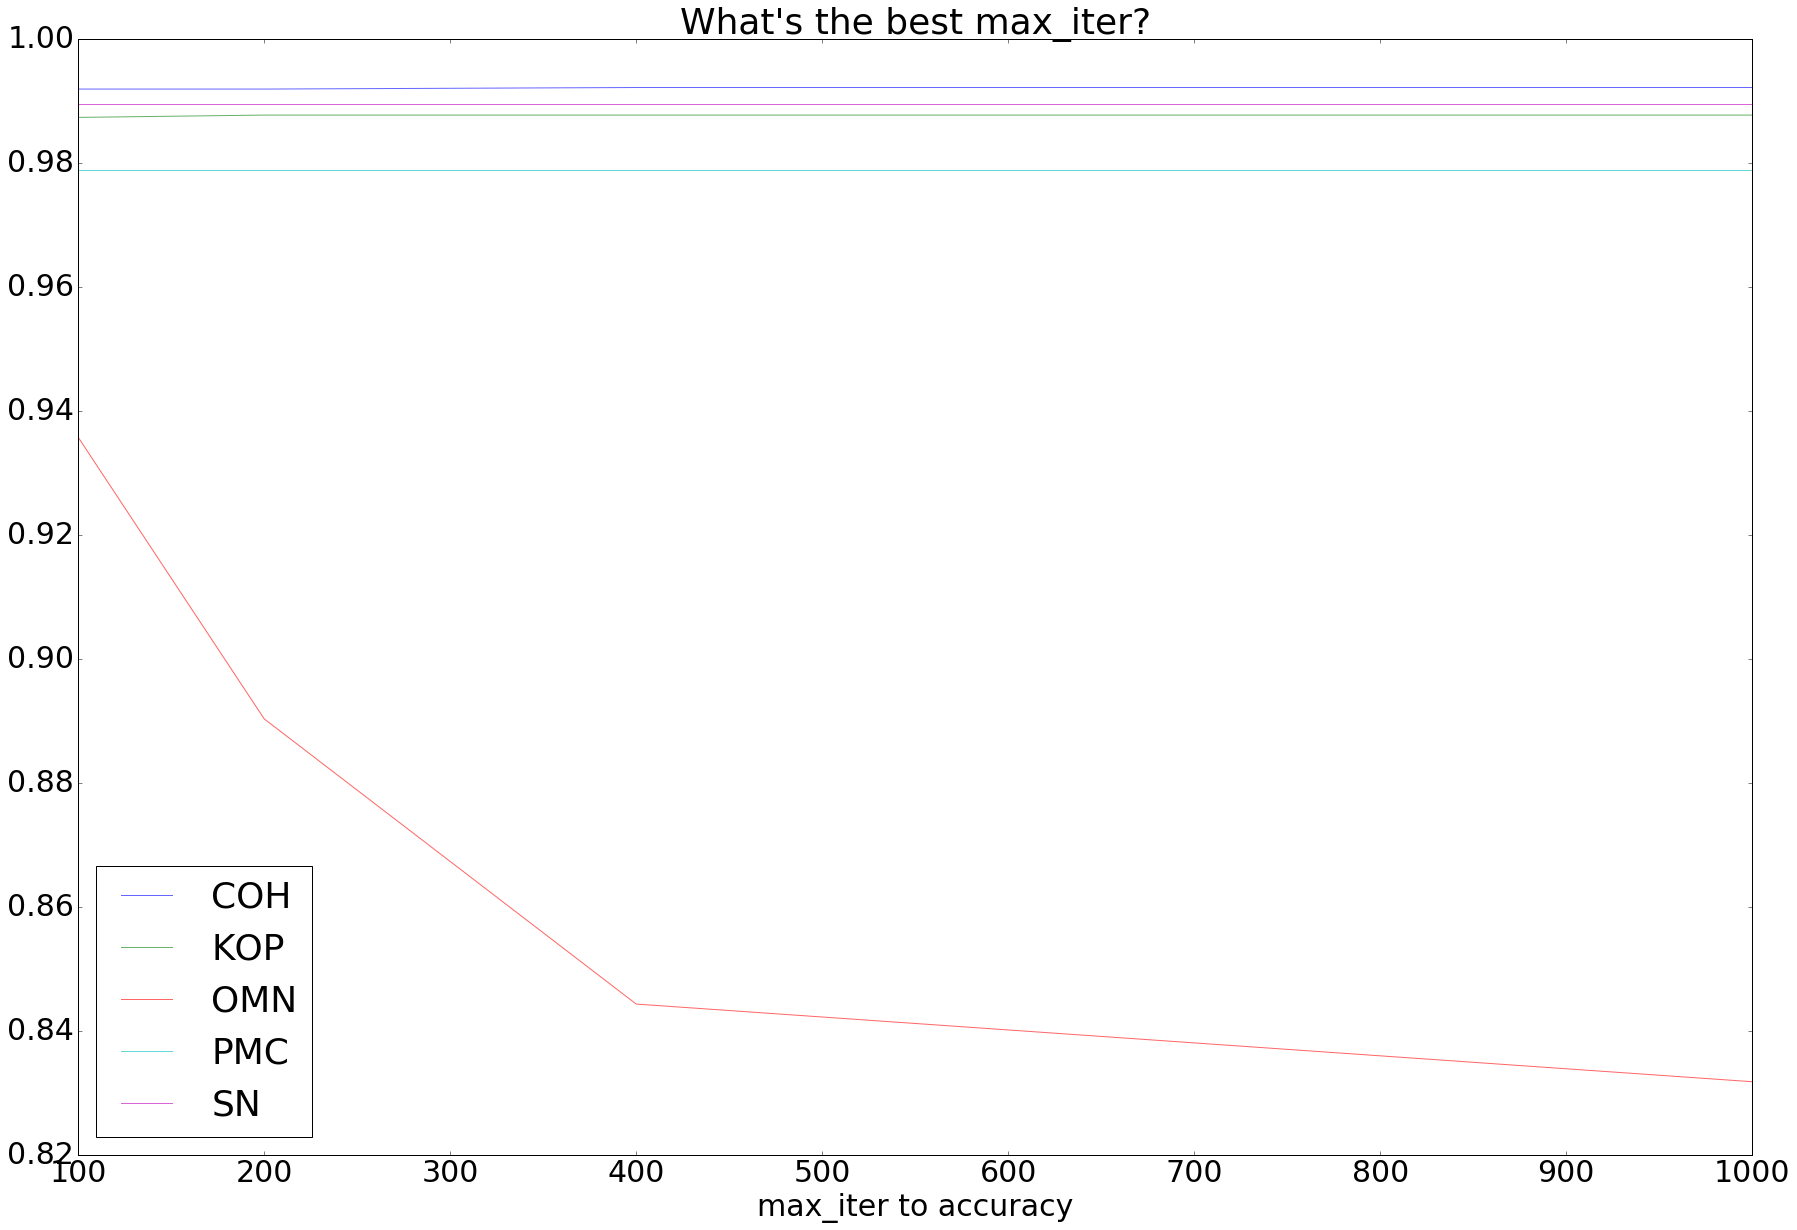

In [48]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

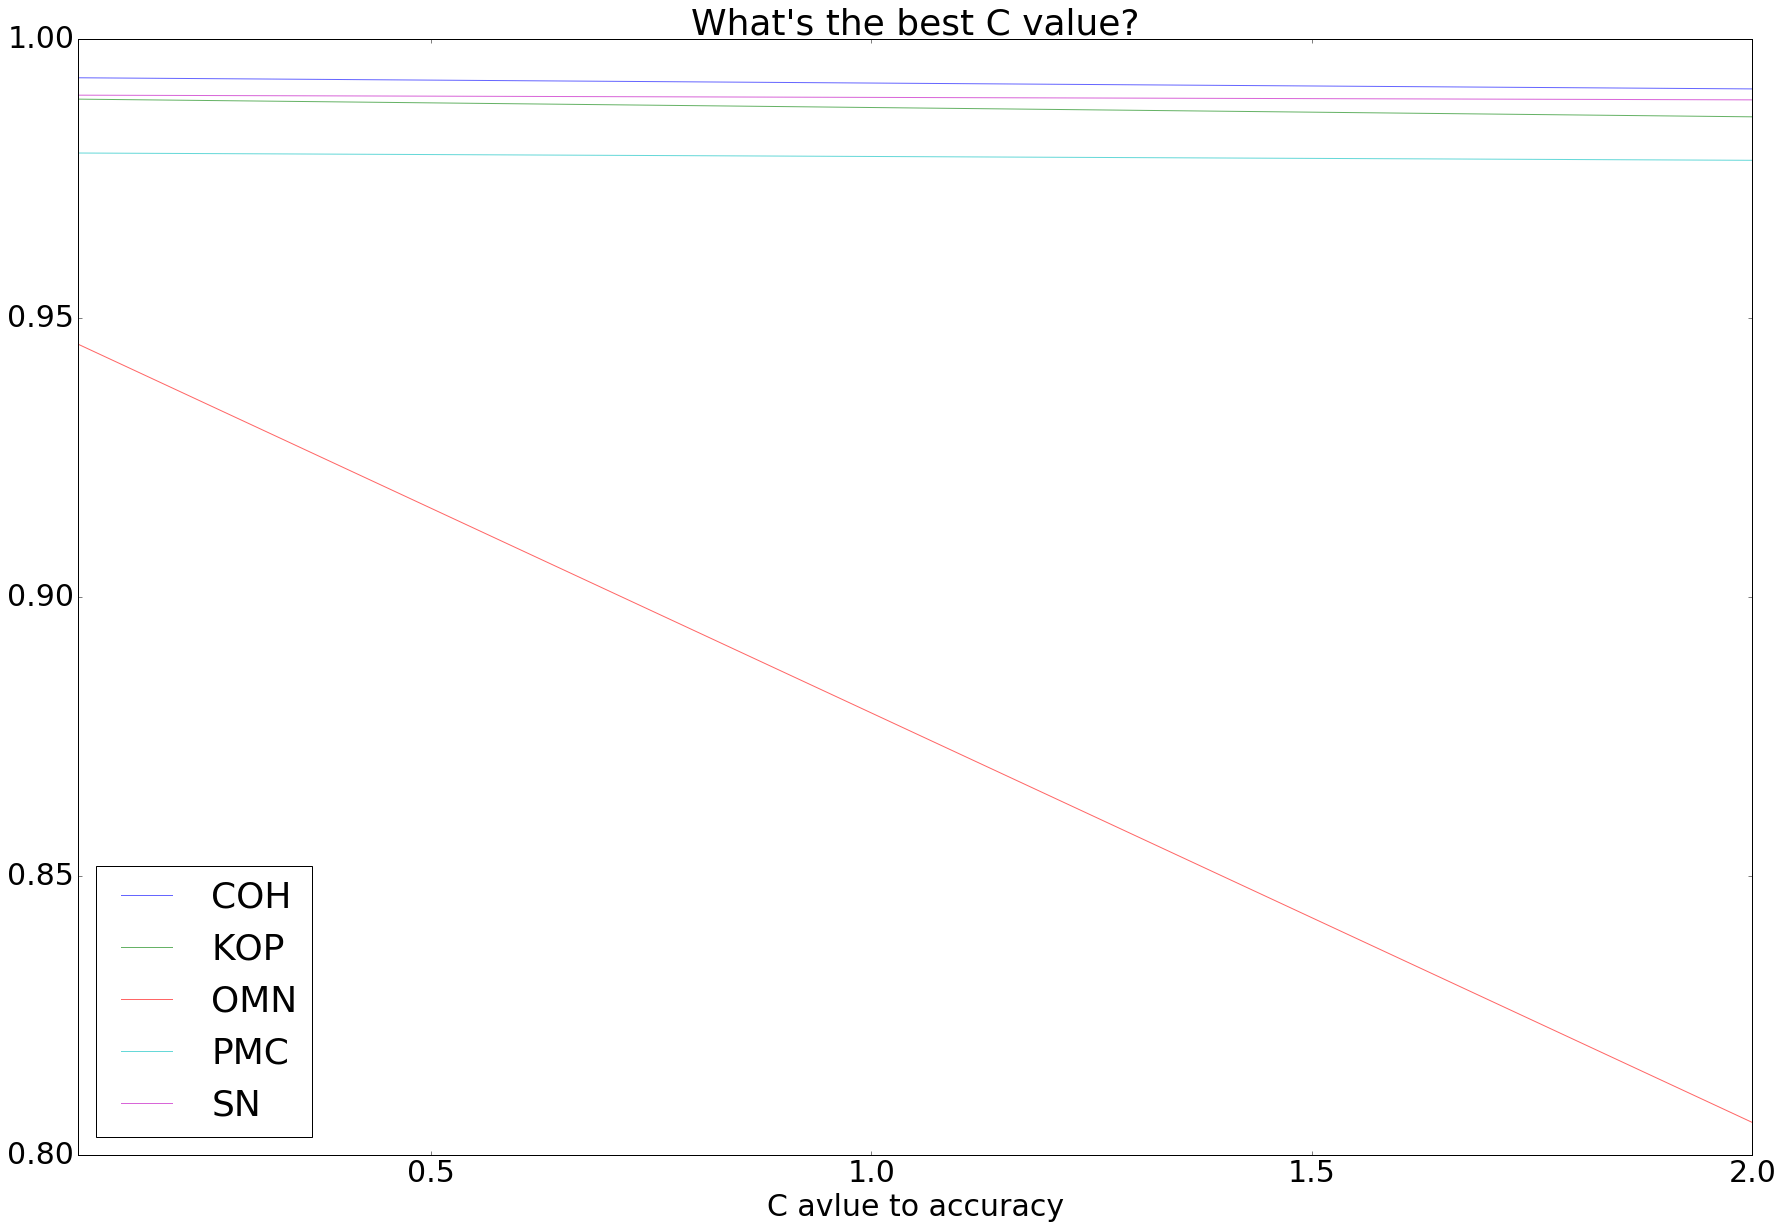

In [49]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

In [50]:
print(get_best_model(s2models, s2accuracies))

(4.9029215014994296, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


So we have a conclusion on the best SVC model.

Let us look at Logistic Regression.

### Logistic Regression

In [51]:
# create iterables for all options and use itertools product
Cs = [0.1, 0.3, 0.5]
intercept_scalings = [1.5, 2, 5, 10]
tols = [0.00001, 0.00004, 0.00007]

l2models = [LogisticRegression(C=c, penalty='l1', intercept_scaling=isc, tol=t) 
          for c, isc, t in product(Cs, intercept_scalings, tols)]

In [52]:
l2accuracies = list(map(run_model, l2models))

In [53]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(l2models, l2accuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.intercept_scaling, model.tol, sn, acc))

l2results = DataFrame(data, columns=('C', 'intercept_scaling', 'tol', 'stock', 'accuracy'))

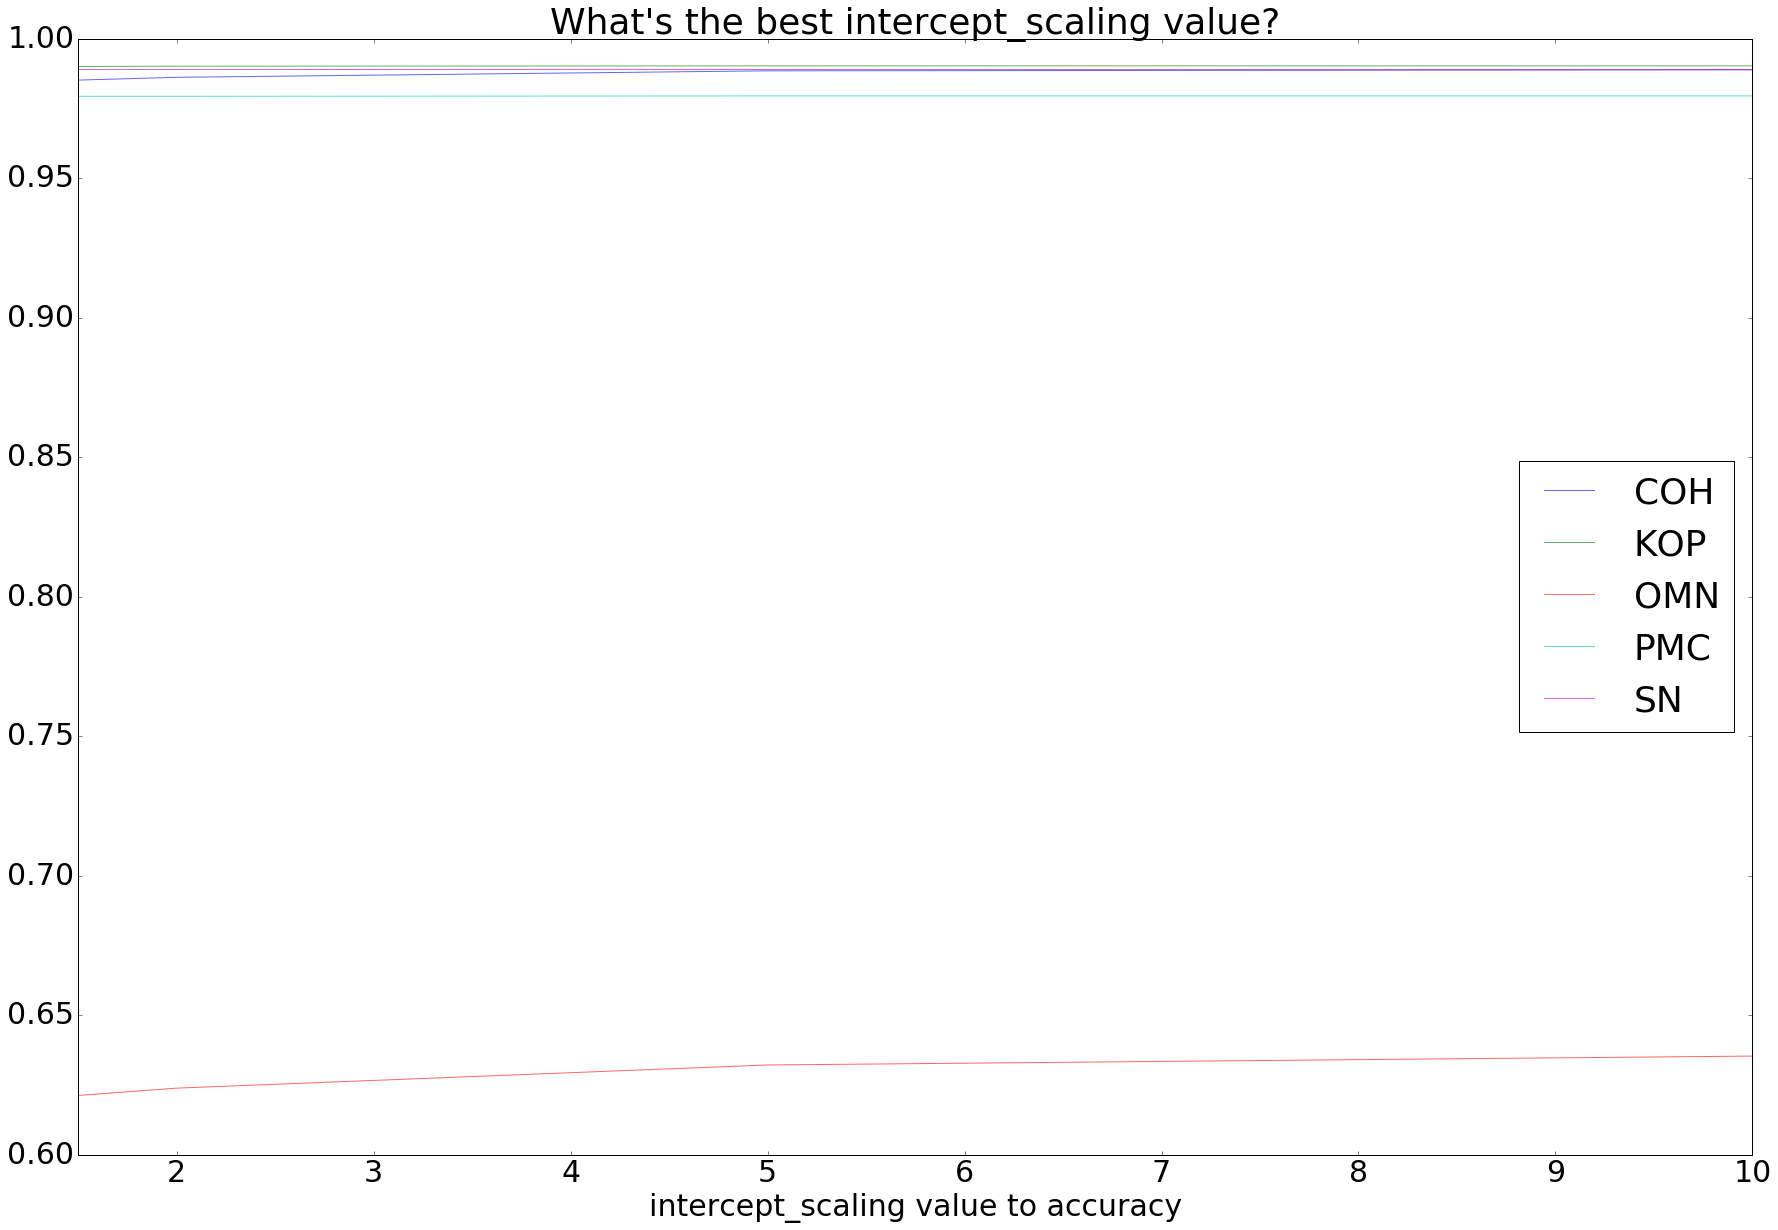

In [55]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in l2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('intercept_scaling value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best intercept_scaling value?" )

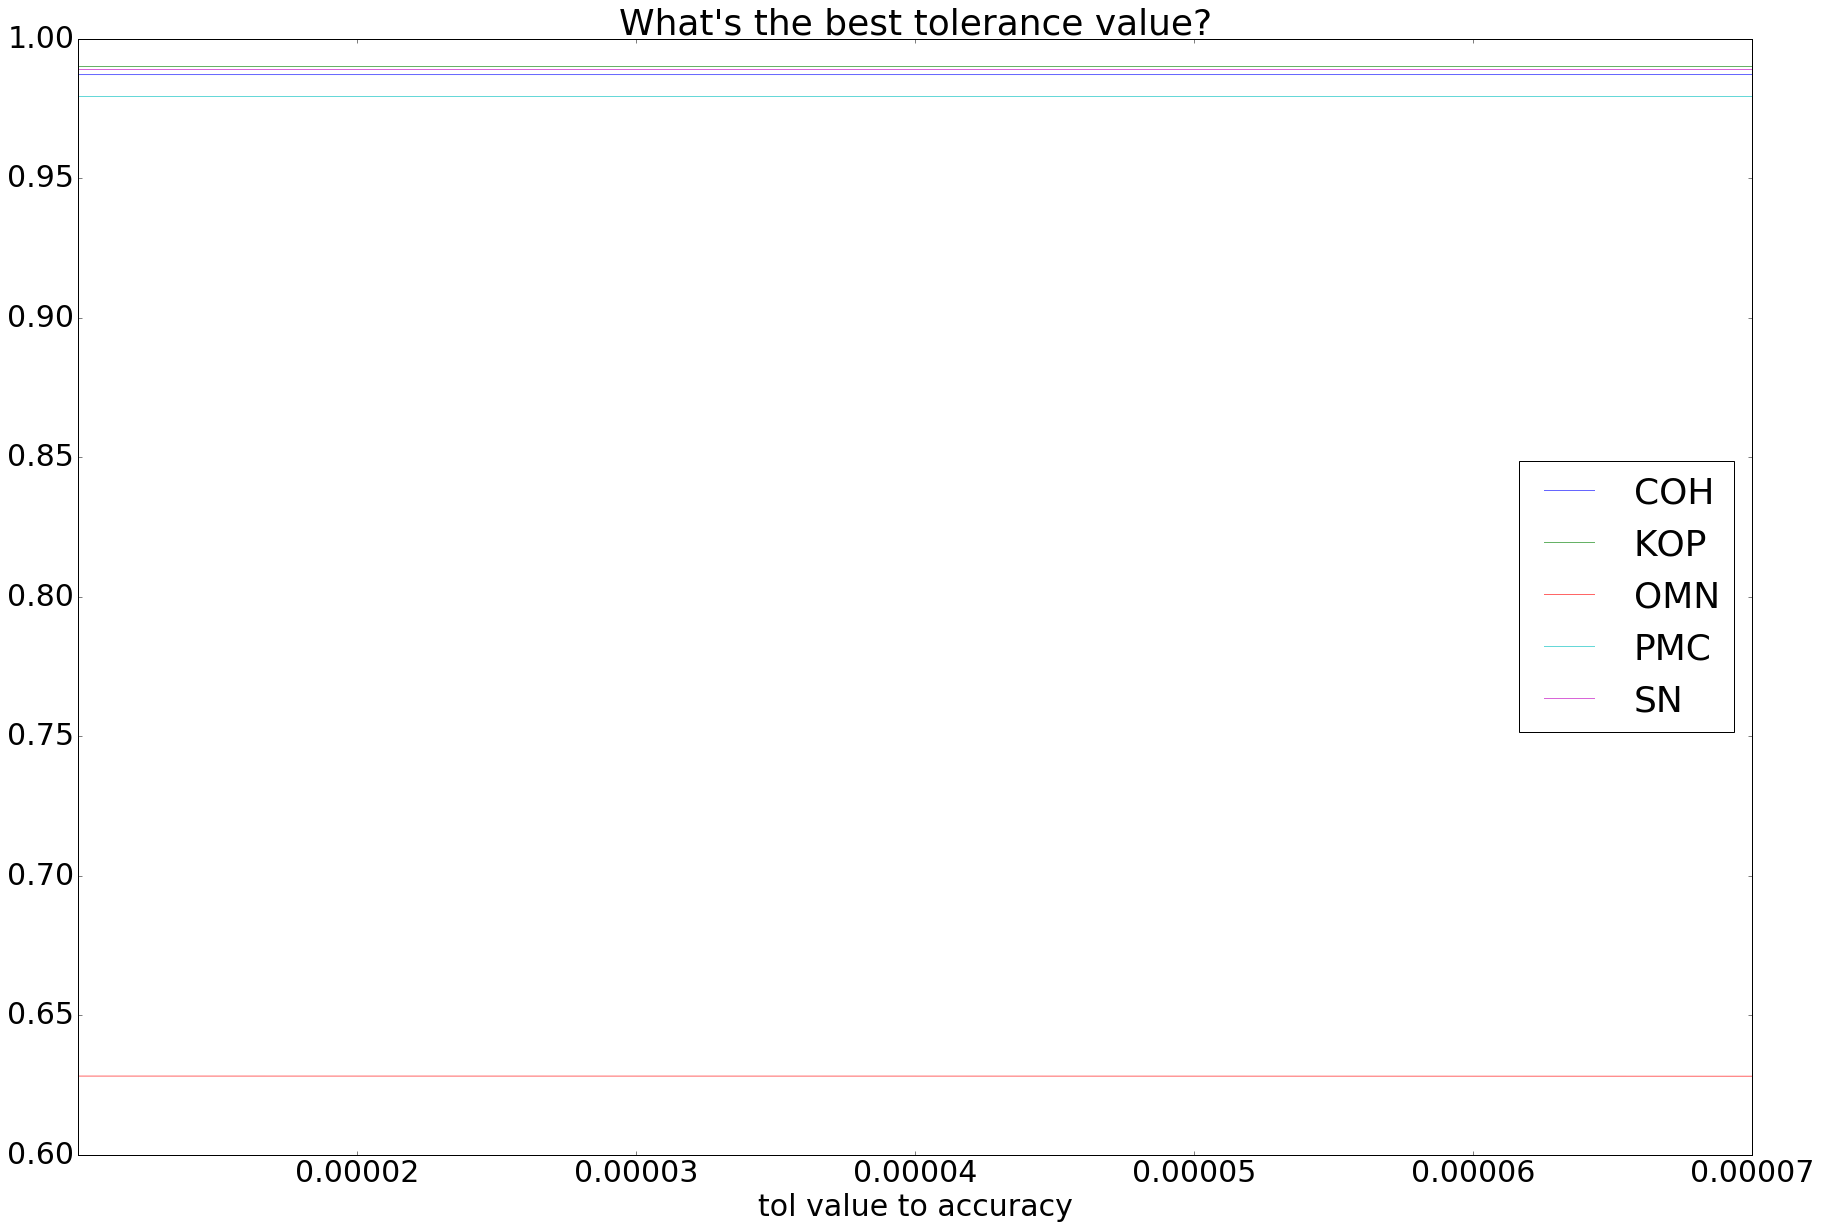

In [56]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in l2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('tol').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('tol value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best tolerance value?" )

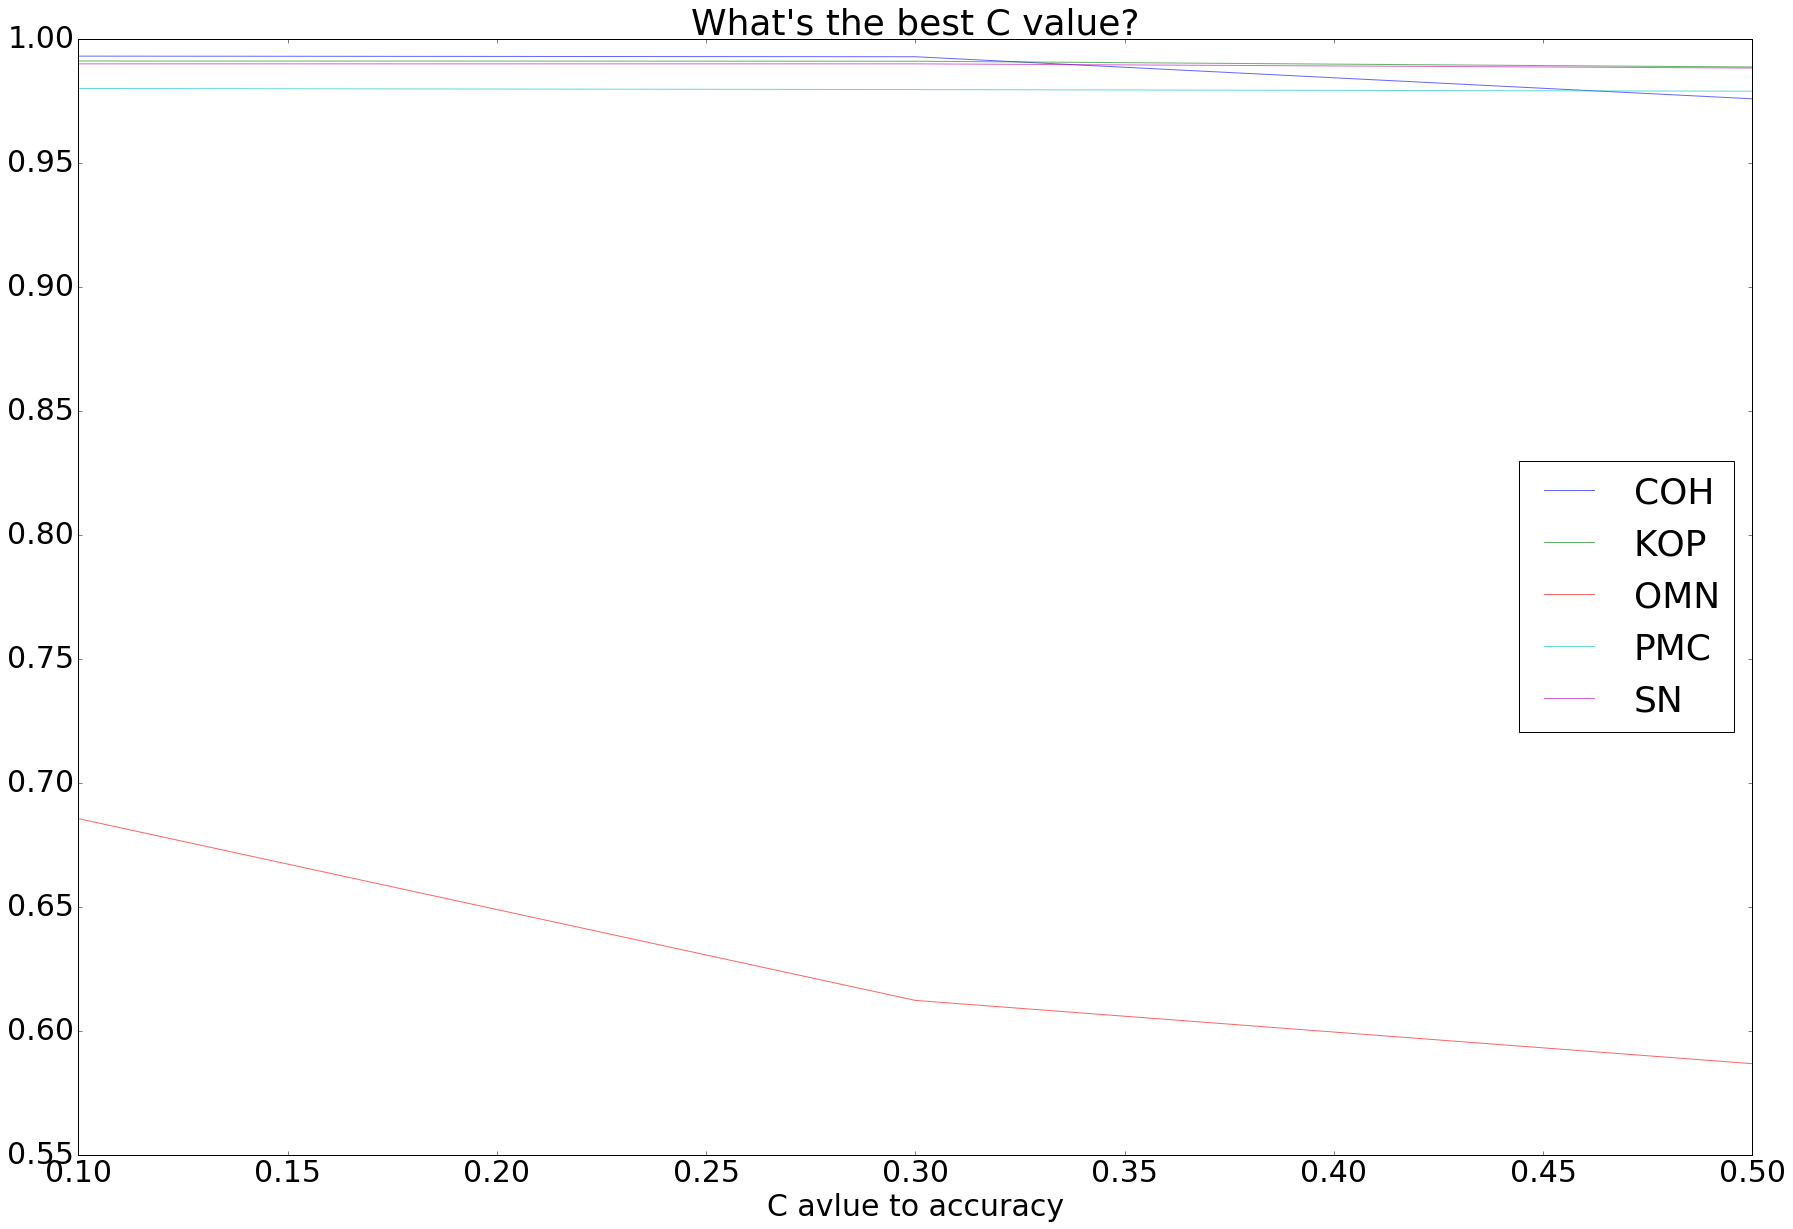

In [57]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in l2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

In [58]:
print(get_best_model(l2models, l2accuracies))

(4.657795849263815, LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=10, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=4e-05,
          verbose=0, warm_start=False))


Ok, So now just one last thing to check, it seems from the graph that although the mean of accuracies is lowest in logsitic regression the median is higher

In [59]:
def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

In [64]:
print(get_best_median_model(l2models, l2accuracies))
print(get_best_model(l2models, l2accuracies))

(0.98989898989898994, LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.5, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False))
(4.657795849263815, LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=10, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=4e-05,
          verbose=0, warm_start=False))


In [65]:
print(get_best_median_model(s2models, s2accuracies))
print(get_best_model(s2models, s2accuracies))

(0.98918717375093212, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
(4.9029215014994296, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


In [66]:
print(get_best_median_model(tmodels, taccuracies))
print(get_best_model(tmodels, taccuracies))

(0.98989898989898994, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(4.9070936020728038, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.05,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


# Conclusion

Amazingly logistic regression and decision tree have the same median. Trees proved to be the best classifier for this issue with a competition from both svm and logistic regression. For the next step (creating the AdaBosst ensemble) we will use all the models above (best avarage and best median) and we expect to see the tree giving the best results (also its training is much faster which will enable more estimators in adaboost).